# figure 15.1

In [2]:
import seaborn as sns
# white background
sns.set_style("white")

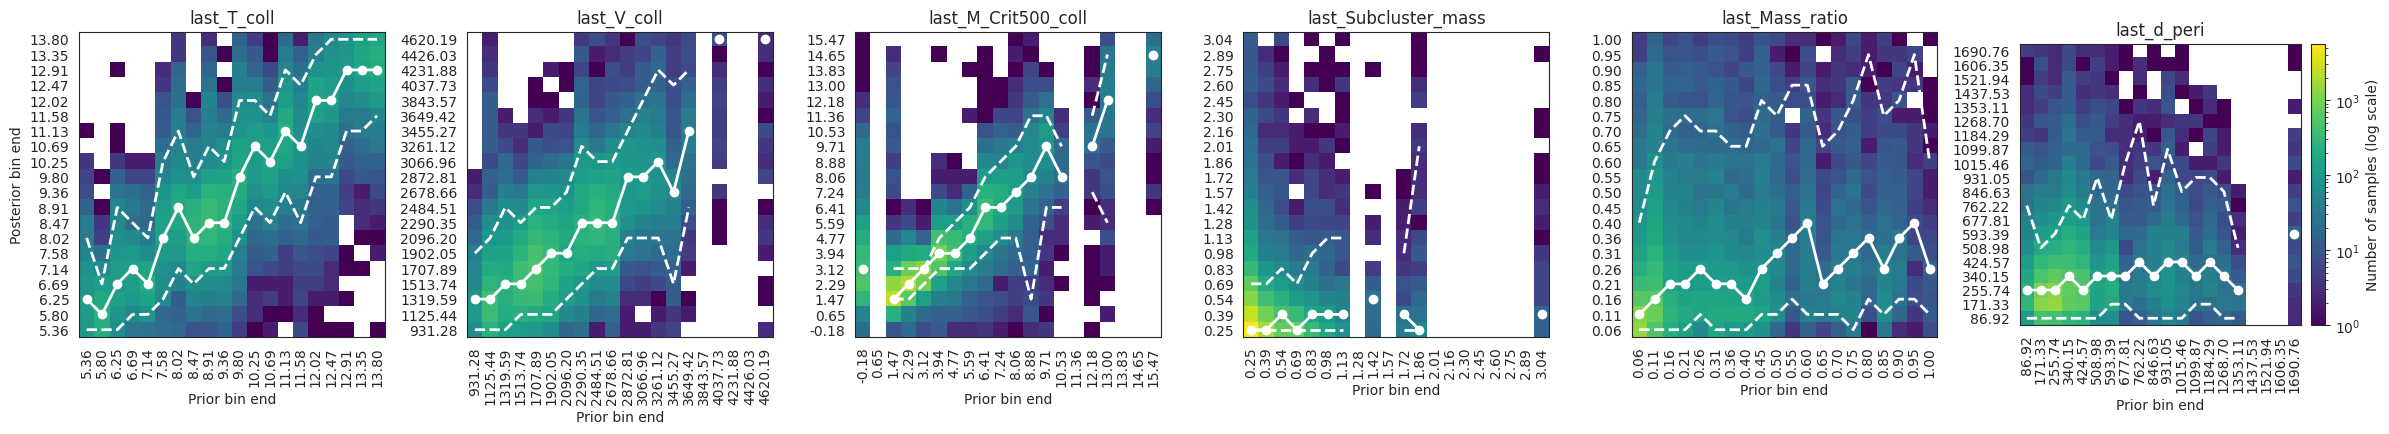

In [9]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    using viridis colormap and a single colorbar at the end.
    """
    # --- Load data & model ---
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _ = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # --- Gather heatmap data for each target ---
    all_data = []
    results  = []
    for d in range(D_tar):
        # true values in physical units
        gt = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)

        # collect posterior samples per bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.zeros(num_bins)
        lo_i   = np.zeros(num_bins)
        hi_i   = np.zeros(num_bins)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # --- Shared LogNorm across all heatmaps ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    vmin = pos.min() if pos.size else 1
    vmax = flat.max()
    norm = LogNorm(vmin=max(1, vmin), vmax=vmax)

    # --- Plot row of subplots + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x = np.arange(num_bins)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )
        ax.plot(x, med_i, marker='o', linestyle='-', linewidth=2, color='white')
        ax.plot(x, lo_i,  linestyle='--', linewidth=2, color='white')
        ax.plot(x, hi_i,  linestyle='--', linewidth=2, color='white')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Prior bin end')
        if d == 0:
            ax.set_ylabel('Posterior bin end')
        ax.set_xticks(x)
        ax.set_xticklabels([f'{e:.2f}' for e in ends], rotation=90)
        ax.set_yticks(x)
        ax.set_yticklabels([f'{e:.2f}' for e in ends])

    # append a single colorbar to the right of the last subplot
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')  # apply viridis to the colorbar
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()
    plt.show()

    return results


if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=100,
        random_state=42,
        num_bins=20
    )


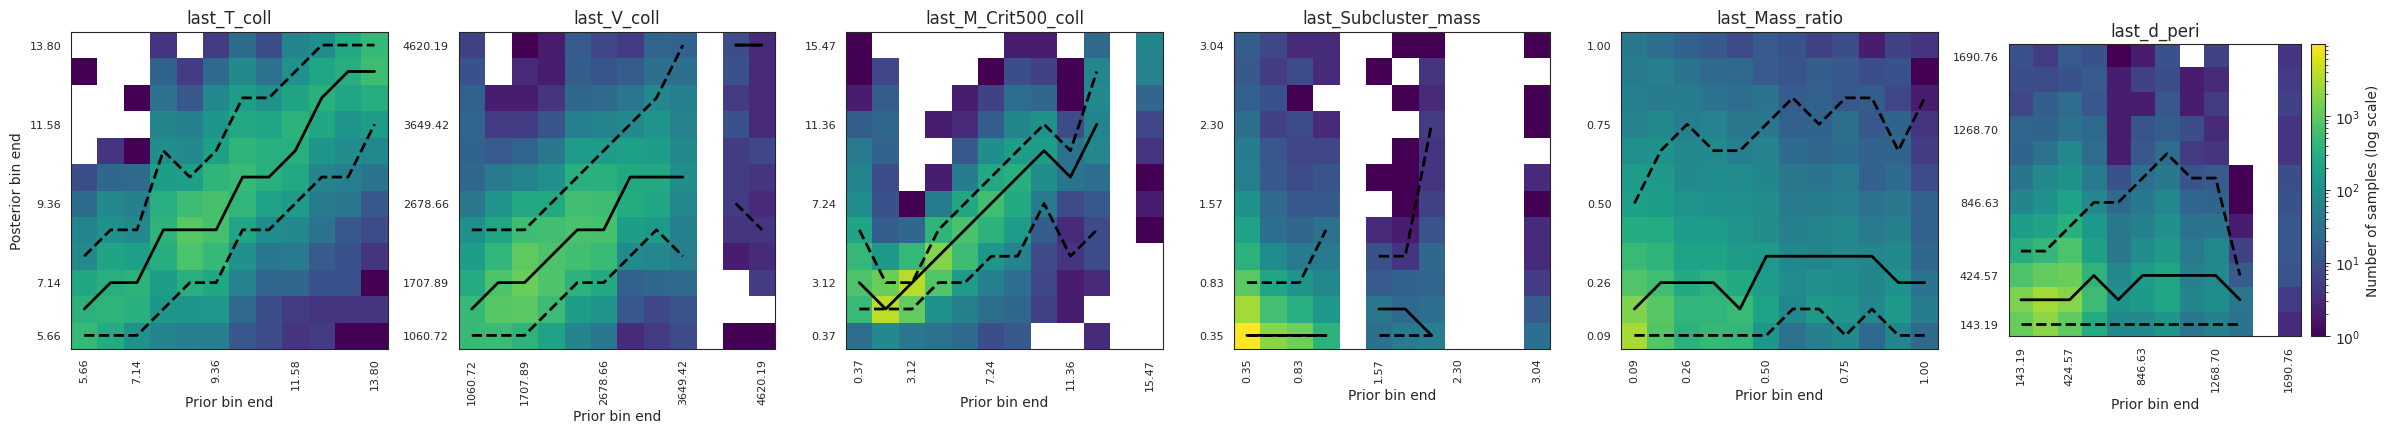

In [20]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    using viridis colormap and a single colorbar at the end.
    Median and 10th/90th percentile lines span all bins;
    ticks are shown sparsely.
    """
    # --- Load data & model ---
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _    = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx         = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # --- Gather heatmap data for each target ---
    all_data = []
    results  = []
    for d in range(D_tar):
        gt   = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)

        # collect posterior samples per prior-bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.zeros(num_bins)
        lo_i   = np.zeros(num_bins)
        hi_i   = np.zeros(num_bins)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # --- Shared LogNorm across all heatmaps ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    vmin = pos.min() if pos.size else 1
    vmax = flat.max()
    norm = LogNorm(vmin=max(1, vmin), vmax=vmax)

    # --- Plot row of subplots + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    # select up to 5 tick positions evenly spaced
    max_ticks = 5
    tick_positions = np.linspace(0, num_bins - 1,
                                 min(max_ticks, num_bins)).astype(int)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )
        # median line across all bins
        ax.plot(np.arange(num_bins), med_i,
                linestyle='-', linewidth=2, color='black')
        # 10th/90th percentile lines
        ax.plot(np.arange(num_bins), lo_i,
                linestyle='--', linewidth=2, color='black')
        ax.plot(np.arange(num_bins), hi_i,
                linestyle='--', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Prior bin end')
        if d == 0:
            ax.set_ylabel('Posterior bin end')

        # sparse ticks
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           rotation=90, fontsize=8)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           fontsize=8)

    # append a single colorbar to the right of the last subplot
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()
    plt.show()

    return results


if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=100,
        random_state=42,
        num_bins=12
    )


## final 15.1

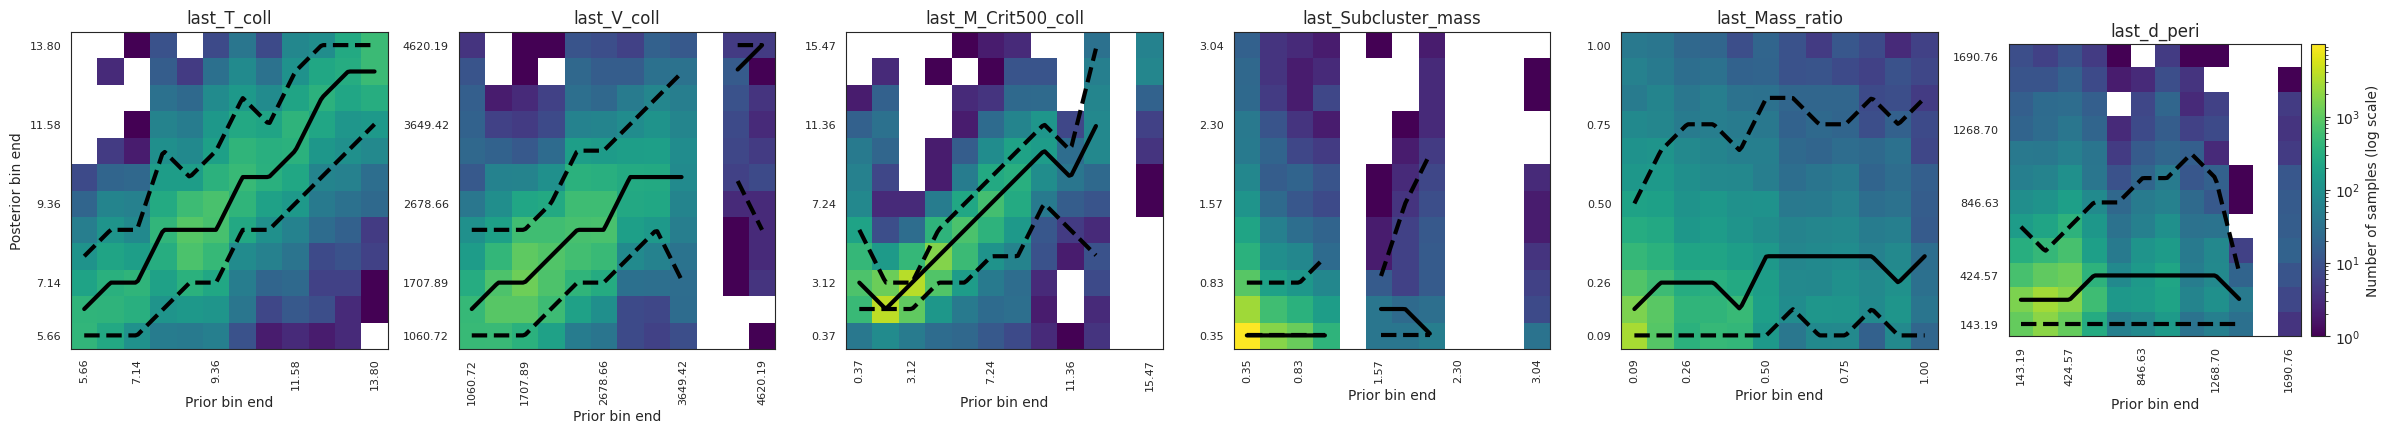

In [22]:
 import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    with viridis colormap, smooth & thicker median/percentile lines,
    and sparse ticks.
    """
    # --- Load data & model ---
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _    = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx         = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # --- Gather heatmap data for each target ---
    all_data = []
    results  = []
    for d in range(D_tar):
        gt   = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)

        # collect posterior samples per prior-bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.zeros(num_bins)
        lo_i   = np.zeros(num_bins)
        hi_i   = np.zeros(num_bins)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # --- Shared LogNorm across all heatmaps ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # --- Plot row of subplots + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    # sparse tick positions
    max_ticks = 5
    tick_positions = np.linspace(0, num_bins - 1,
                                 min(max_ticks, num_bins)).astype(int)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # smooth & thicker median line
        x_bins    = np.arange(num_bins)
        x_smooth  = np.linspace(0, num_bins - 1, num_bins * 10)
        med_smooth = np.interp(x_smooth, x_bins, med_i)
        lo_smooth  = np.interp(x_smooth, x_bins, lo_i)
        hi_smooth  = np.interp(x_smooth, x_bins, hi_i)

        ax.plot(x_smooth, med_smooth,  linestyle='-', linewidth=3, color='black')
        ax.plot(x_smooth, lo_smooth,   linestyle='--', linewidth=3, color='black')
        ax.plot(x_smooth, hi_smooth,   linestyle='--', linewidth=3, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Prior bin end')
        if d == 0:
            ax.set_ylabel('Posterior bin end')

        # apply sparse ticks
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           rotation=90, fontsize=8)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           fontsize=8)

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()
    plt.show()

    return results


if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=100,
        random_state=42,
        num_bins=12
    )


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    but only for bins between the 5th and 95th percentile of the true distribution.
    Uses viridis colormap and a single colorbar.
    """
    # Load data & model
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _ = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    all_data = []
    results  = []

    # Gather and filter heatmap data per target
    for d in range(D_tar):
        gt = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        p5, p95 = np.percentile(gt, [1, 99])
        b_lo = np.searchsorted(bins, p5, side='right') - 1
        b_hi = np.searchsorted(bins, p95, side='left') - 1
        b_lo = np.clip(b_lo, 0, num_bins-1)
        b_hi = np.clip(b_hi, b_lo, num_bins-1)
        keep = np.arange(b_lo, b_hi + 1)

        bin_idx = np.digitize(gt, bins[1:-1], right=False)
        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i = np.zeros(num_bins)
        lo_i  = np.zeros(num_bins)
        hi_i  = np.zeros(num_bins)

        # first pass: count posterior samples per prior bin
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.detach().cpu().numpy())[:, d]
                counts[b], _ = np.histogram(phys, bins=bins)

        # second pass: compute median, 10th, 90th percentiles per prior bin
        for b in range(num_bins):
            idxs = np.where(bin_idx == b)[0]
            if idxs.size:
                samples = []
                for i in idxs:
                    x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                    Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                    inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                    Ys  = inv[0] if isinstance(inv, tuple) else inv
                    samples.append(tar_sc.inverse_transform(Ys.detach().cpu().numpy())[:, d])
                arr = np.concatenate(samples)
                med = np.median(arr)
                lo  = np.percentile(arr, 10)
                hi  = np.percentile(arr, 90)
                med_i[b] = np.clip(np.digitize(med, bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(lo,  bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(hi,  bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data_full = counts.T
        data = data_full[keep][:, keep]
        med_plot = med_i[keep] - b_lo
        lo_plot  = lo_i[keep]  - b_lo
        hi_plot  = hi_i[keep]  - b_lo
        edges = bins[keep + 1]

        all_data.append(data)
        results.append((data, med_plot, lo_plot, hi_plot, edges))

    # Shared log norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # Plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, edges = results[d]
        x = np.arange(data.shape[0])

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )
        ax.plot(x, med_i, marker='o', linestyle='-', linewidth=2, color='white')
        ax.plot(x, lo_i,  linestyle='--', linewidth=2, color='white')
        ax.plot(x, hi_i,  linestyle='--', linewidth=2, color='white')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Prior bin end')
        if d == 0:
            ax.set_ylabel('Posterior bin end')
        ax.set_xticks(x)
        ax.set_xticklabels([f'{e:.2f}' for e in edges], rotation=90)
        ax.set_yticks(x)
        ax.set_yticklabels([f'{e:.2f}' for e in edges])

    # Colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()
    plt.show()

    return results

if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=300,
        random_state=42,
        num_bins=20
    )


KeyboardInterrupt: 

# figure 15.2

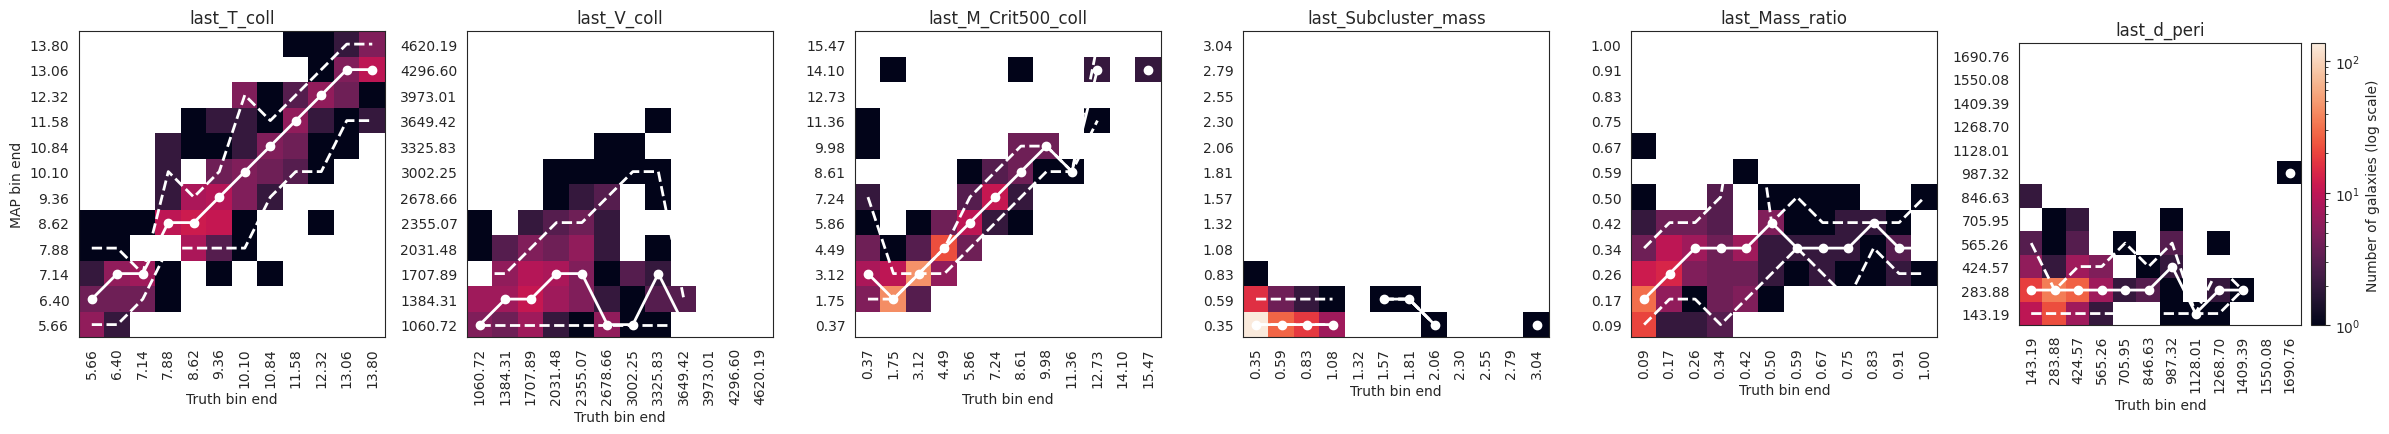

In [26]:
import os

import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]


def plot_map_vs_truth_2d_hist(model_checkpoint: str,
                              processed_dir: str = "processed_data",
                              n_posterior_samples: int = 600,
                              num_bins: int = 10,
                              random_state: int = 42):
    """
    For each target dimension:
      • Compute cINN MAP per test galaxy via KDE on n_posterior_samples.
      • Build 2D histogram of (truth, MAP) in num_bins × num_bins.
      • Overlay median and 10th/90th percentile MAP‐bin lines.
      • Plot all targets in one row, with a colorbar at the far right.
    """
    # 1) load
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    obs_sc  = joblib.load(os.path.join(processed_dir, "obs_scaler.pkl"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full  = dfX.values
    Y_full  = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAP for each test galaxy & each target
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    rng = np.random.RandomState(random_state)
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)
        # KDE per-dimension
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) prepare heatmap data for each target
    all_data = []
    percentiles = []
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]

        # bins on truth axis
        tmin, tmax = truth.min(), truth.max()
        bins = np.linspace(tmin, tmax, num_bins+1)

        # digitize truth to assign columns
        t_idx = np.digitize(truth, bins[1:-1], right=False)

        # build counts matrix prior×posterior
        counts = np.zeros((num_bins, num_bins), int)
        # collect map values per truth-bin
        bin_to_map = {b: [] for b in range(num_bins)}
        for i, b in enumerate(t_idx):
            if 0 <= b < num_bins:
                bin_to_map[b].append(mapv[i])

        for b in range(num_bins):
            arr = np.array(bin_to_map[b])
            if arr.size:
                # histogram map values into same bins
                c, _ = np.histogram(arr, bins=bins)
                counts[b] = c

        # compute median & 10th/90th percentile of MAP per truth-bin
        med = np.full(num_bins, np.nan)
        lo  = np.full(num_bins, np.nan)
        hi  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            arr = np.array(bin_to_map[b])
            if arr.size:
                med[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins-1)
                lo[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins-1)
                hi[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins-1)

        data = counts.T  # x=truth, y=MAP
        all_data.append(data)
        percentiles.append((med, lo, hi, bins))

    # 6) shared log-norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat>0]
    vmin = pos.min() if pos.size else 1
    vmax = flat.max()
    norm = LogNorm(vmin=max(1, vmin), vmax=vmax)

    # 7) plot row of subplots
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar, 5), squeeze=False)
    x = np.arange(num_bins)
    for d, ax in enumerate(axes[0]):
        data, (med, lo, hi, bins) = all_data[d], percentiles[d]
        ends = bins[1:]
        ticks = np.arange(num_bins)

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest'
        )
        ax.plot(x, med, marker='o', linestyle='-', linewidth=2, color='white')
        ax.plot(x, lo,  linestyle='--', linewidth=2, color='white')
        ax.plot(x, hi,  linestyle='--', linewidth=2, color='white')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin end')
        if d == 0:
            ax.set_ylabel('MAP bin end')
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{e:.2f}' for e in ends], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{e:.2f}' for e in ends])

    # colorbar on the right
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Number of galaxies (log scale)')

    plt.tight_layout()
    plt.show()
    return

if __name__ == "__main__":
    plot_map_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=12,
        random_state=42
    )


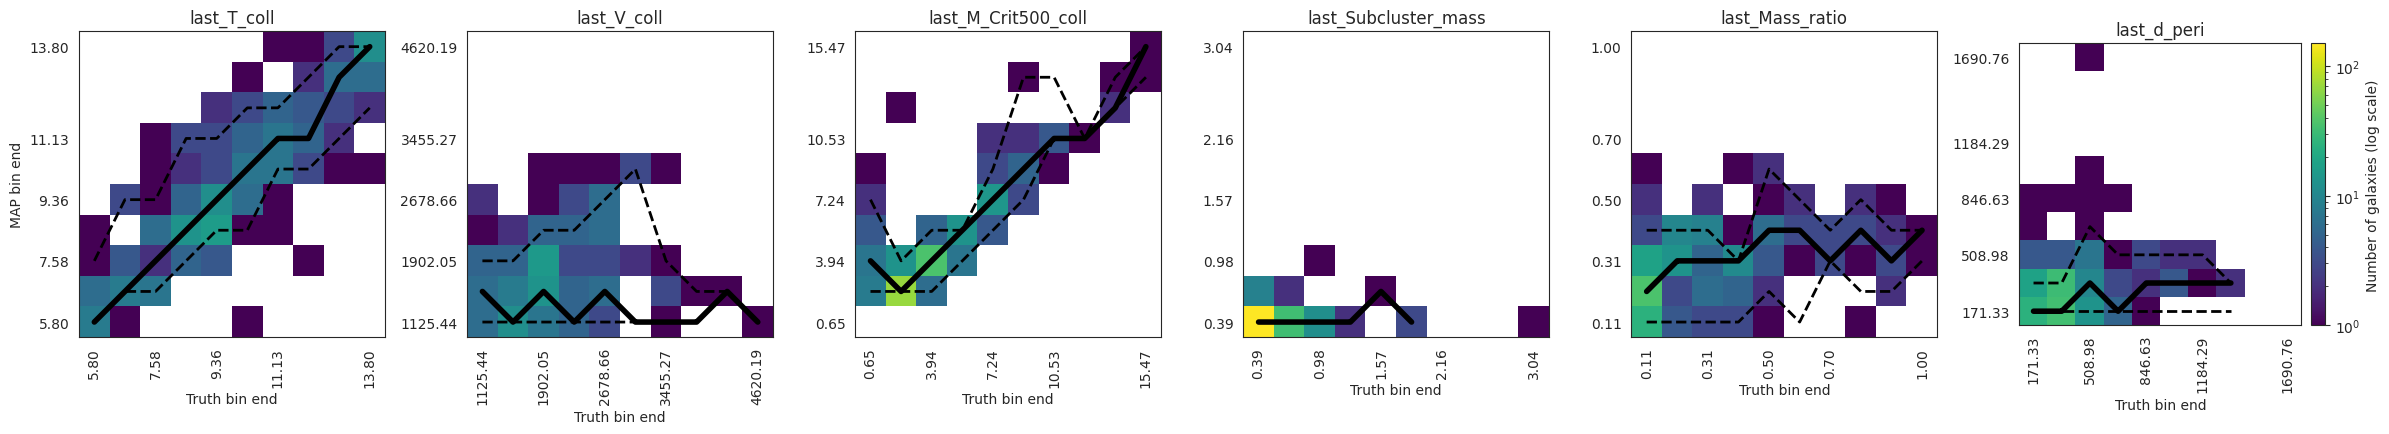

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_vs_truth_2d_hist(model_checkpoint: str,
                              processed_dir: str = "processed_data",
                              n_posterior_samples: int = 600,
                              num_bins: int = 10,
                              random_state: int = 42):
    """
    For each target:
      • Compute cINN MAP per test galaxy via KDE on n_posterior_samples.
      • Build 2D histogram of (truth, MAP) in num_bins × num_bins.
      • Overlay smooth, thick median line and dashed 10th/90th percentile lines.
      • Plot all targets in one row with a viridis colorbar at the end.
    """
    # 1) load data & scalers
    dfX     = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY     = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc  = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) split into test
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # 4) compute MAP estimates
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) prepare 2D histograms + percentiles
    all_data, percentiles = [], []
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        tmin, tmax = truth.min(), truth.max()
        bins = np.linspace(tmin, tmax, num_bins + 1)
        t_idx = np.digitize(truth, bins[1:-1], right=False)

        counts = np.zeros((num_bins, num_bins), int)
        bin_to_map = {b: [] for b in range(num_bins)}
        for i, b in enumerate(t_idx):
            if 0 <= b < num_bins:
                bin_to_map[b].append(mapv[i])
        for b in range(num_bins):
            arr = np.array(bin_to_map[b])
            if arr.size:
                c, _ = np.histogram(arr, bins=bins)
                counts[b] = c

        med, lo, hi = np.full(num_bins, np.nan), np.full(num_bins, np.nan), np.full(num_bins, np.nan)
        for b in range(num_bins):
            arr = np.array(bin_to_map[b])
            if arr.size:
                med[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)

        all_data.append(counts.T)
        percentiles.append((med, lo, hi, bins))

    # 6) shared log-norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x_bins = np.arange(num_bins)
    x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)

    for d, ax in enumerate(axes[0]):
        data, (med, lo, hi, bins) = all_data[d], percentiles[d]
        ends = bins[1:]
        im = ax.imshow(data, origin='lower', norm=norm, aspect='equal',
                       interpolation='nearest', cmap='viridis')

        # smooth & thick median line
        med_smooth = np.interp(x_smooth, x_bins, med)
        ax.plot(x_smooth, med_smooth, linestyle='-', linewidth=4, color='black')

        # dashed 10th/90th percentiles (unsmoothed)
        ax.plot(x_bins, lo, linestyle='--', linewidth=2, color='black')
        ax.plot(x_bins, hi, linestyle='--', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin end')
        if d == 0:
            ax.set_ylabel('MAP bin end')
        ticks = np.linspace(0, num_bins - 1, min(5, num_bins), dtype=int)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in ticks], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in ticks])

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of galaxies (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=10,
        random_state=42
    )


# figure 15.3

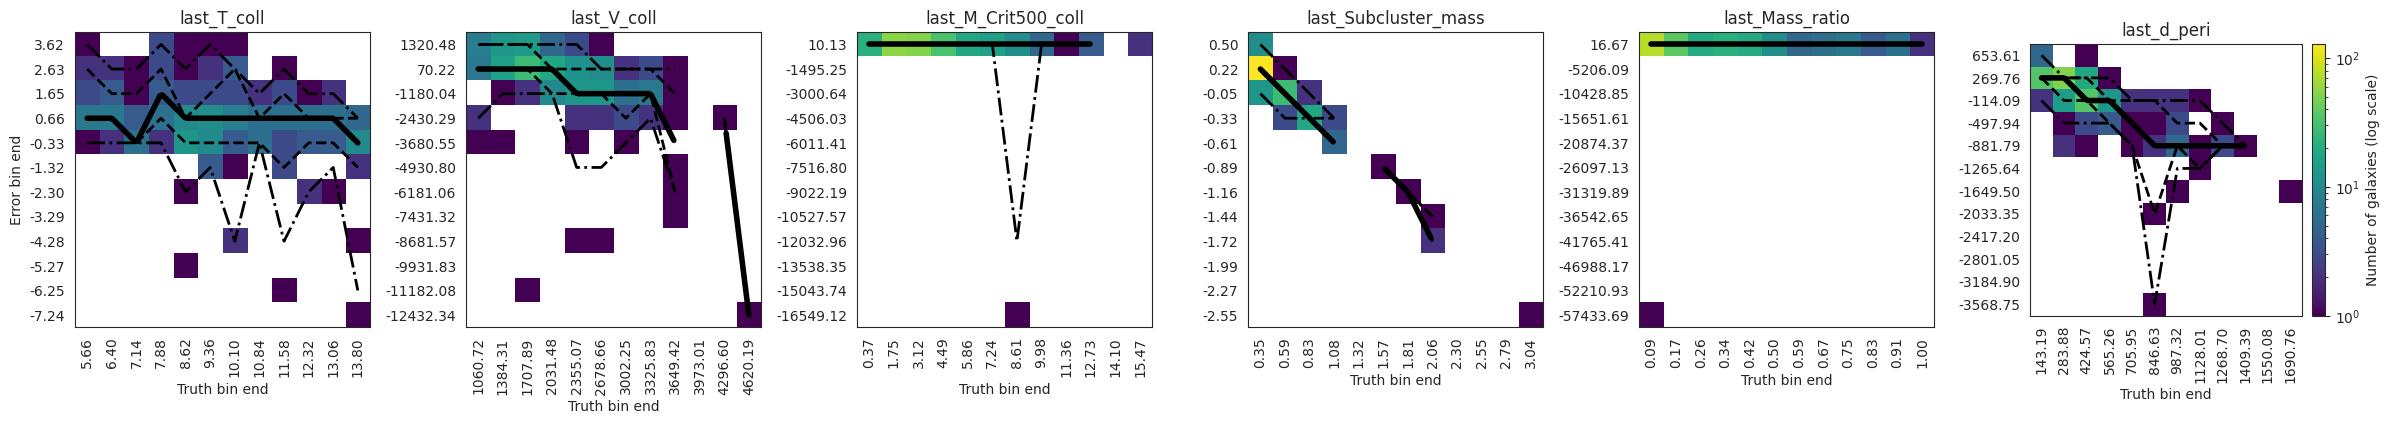

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_2d_hist(model_checkpoint: str,
                                    processed_dir: str = "processed_data",
                                    n_posterior_samples: int = 600,
                                    num_bins: int = 10,
                                    random_state: int = 42):
    """
    For each target:
      • Compute MAP via KDE on n_posterior_samples per test galaxy.
      • Compute error = MAP - truth.
      • Build 2D histogram of (truth, error) with num_bins × num_bins.
      • Overlay thick black median error line (smoothed),
        dashed black 1σ (16–84%) and dash-dot black 2σ (2.5–97.5%) lines.
      • Plot all targets in one row with a viridis log‐scaled colorbar on the right.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) prepare histogram data and percentile lines
    all_data = []
    stats    = []
    for d in range(D_tar):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # define bins for truth and error axes
        tmin, tmax = truth.min(), truth.max()
        emin, emax = error.min(), error.max()
        tbins = np.linspace(tmin, tmax, num_bins + 1)
        ebins = np.linspace(emin, emax, num_bins + 1)

        # digitize truth to assign truth-bin
        t_idx = np.digitize(truth, tbins[1:-1], right=False)

        # build 2D histogram counts
        counts = np.zeros((num_bins, num_bins), dtype=int)
        bin_to_err = {b: [] for b in range(num_bins)}
        for i, b in enumerate(t_idx):
            if 0 <= b < num_bins:
                bin_to_err[b].append(error[i])
        for b in range(num_bins):
            arr = np.array(bin_to_err[b])
            if arr.size:
                c, _ = np.histogram(arr, bins=ebins)
                counts[b] = c

        # compute median and percentiles (in bin indices)
        med_i  = np.full(num_bins, np.nan)
        lo1_i  = np.full(num_bins, np.nan)
        hi1_i  = np.full(num_bins, np.nan)
        lo2_i  = np.full(num_bins, np.nan)
        hi2_i  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            arr = np.array(bin_to_err[b])
            if arr.size:
                med_i[b]  = np.clip(np.digitize(np.median(arr),   ebins) - 1, 0, num_bins-1)
                lo1_i[b]  = np.clip(np.digitize(np.percentile(arr, 16), ebins) - 1, 0, num_bins-1)
                hi1_i[b]  = np.clip(np.digitize(np.percentile(arr, 84), ebins) - 1, 0, num_bins-1)
                lo2_i[b]  = np.clip(np.digitize(np.percentile(arr, 2.5), ebins) - 1, 0, num_bins-1)
                hi2_i[b]  = np.clip(np.digitize(np.percentile(arr, 97.5), ebins) - 1, 0, num_bins-1)

        all_data.append(counts.T)
        stats.append((med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins))

    # 6) shared log-norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    vmin = max(1, pos.min() if pos.size else 1)
    vmax = flat.max()
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # 7) plot row of subplots
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x_bins    = np.arange(num_bins)
    x_smooth  = np.linspace(0, num_bins - 1, num_bins * 10)

    for d, ax in enumerate(axes[0]):
        data, (med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins) = all_data[d], stats[d]
        t_ends = tbins[1:]
        e_ends = ebins[1:]
        ticks  = np.arange(num_bins)

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # thick black median line (smoothed)
        med_smooth = np.interp(x_smooth, x_bins, med_i)
        ax.plot(x_smooth, med_smooth, '-', linewidth=4, color='black')

        # dashed black 1σ region
        ax.plot(x_bins, lo1_i, '--', linewidth=2, color='black')
        ax.plot(x_bins, hi1_i, '--', linewidth=2, color='black')

        # dash-dot black 2σ region
        ax.plot(x_bins, lo2_i, '-.', linewidth=2, color='black')
        ax.plot(x_bins, hi2_i, '-.', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin end')
        if d == 0:
            ax.set_ylabel('Error bin end')
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{v:.2f}' for v in t_ends], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{v:.2f}' for v in e_ends])

    # append a shared colorbar to the right of the last subplot
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of galaxies (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=12,
        random_state=42
    )


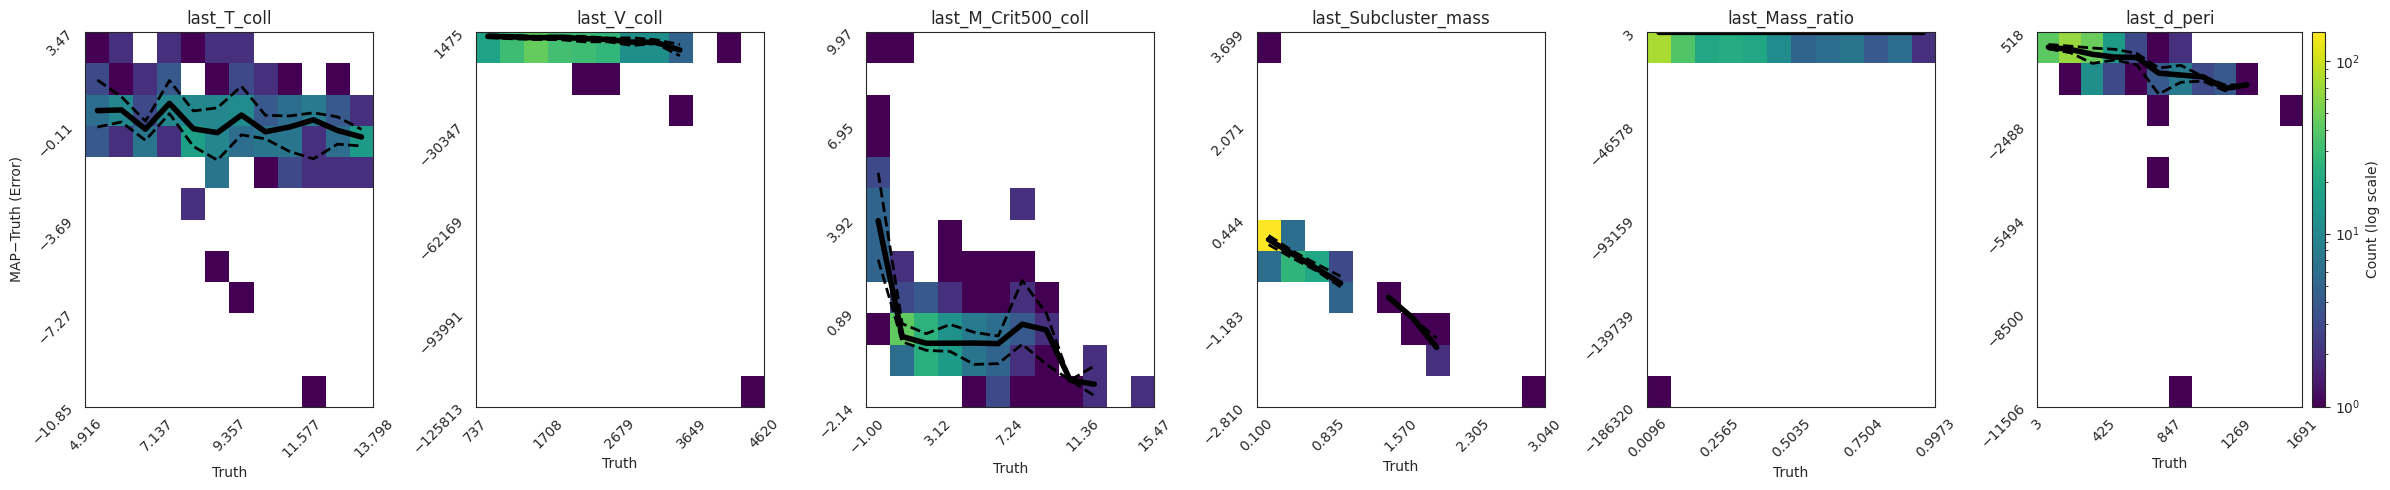

In [43]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_2d_hist(model_checkpoint: str,
                                    processed_dir: str = "processed_data",
                                    n_posterior_samples: int = 600,
                                    num_bins: int = 10,
                                    random_state: int = 42):
    """
    For each target:
      • Compute MAP via KDE on n_posterior_samples per test galaxy.
      • Compute error = MAP - truth.
      • Build 2D histogram of (truth, error) with num_bins × num_bins.
      • Overlay thick black median error line (no markers),
        and dashed black 1st/99th percentile lines.
      • Plot all targets in one row with a viridis log‐scaled colorbar on the right.
      Percentile lines are plotted in true value units (y-axis).
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test    = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) prepare histogram data and percentile curves
    all_data = []
    stats    = []
    for d in range(D_tar):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # define bins for truth and error axes
        tmin, tmax = truth.min(), truth.max()
        emin, emax = error.min(), error.max()
        tbins = np.linspace(tmin, tmax, num_bins + 1)
        ebins = np.linspace(emin, emax, num_bins + 1)

        # 2D histogram counts
        counts, _, _ = np.histogram2d(truth, error, bins=[tbins, ebins])

        # bin-centers for truth
        t_centers = 0.5 * (tbins[:-1] + tbins[1:])

        # compute median and 1st/99th percentiles in error per truth-bin
        med_vals = np.full(num_bins, np.nan)
        lo1_vals = np.full(num_bins, np.nan)
        hi1_vals = np.full(num_bins, np.nan)
        for b in range(num_bins):
            mask = (truth >= tbins[b]) & (truth < tbins[b+1])
            errs = error[mask]
            if errs.size:
                med_vals[b]  = np.median(errs)
                lo1_vals[b]  = np.percentile(errs, 20)
                hi1_vals[b]  = np.percentile(errs, 80)

        all_data.append(counts.T)  # transpose to match imshow origin='lower'
        stats.append((t_centers, med_vals, lo1_vals, hi1_vals, tbins, ebins))

    # 6) shared log-norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        counts = all_data[d]
        t_centers, med_vals, lo1_vals, hi1_vals, tbins, ebins = stats[d]
        e_min, e_max = ebins[0], ebins[-1]

        im = ax.imshow(
            counts,
            origin='lower',
            norm=norm,
            aspect='auto',
            interpolation='nearest',
            cmap='viridis',
            extent=[tbins[0], tbins[-1], ebins[0], ebins[-1]]
        )

        # thick black median line
        ax.plot(t_centers, med_vals, '-', linewidth=4, color='black')

        # dashed black 1st/99th percentile
        ax.plot(t_centers, lo1_vals, '--', linewidth=2, color='black')
        ax.plot(t_centers, hi1_vals, '--', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth')
        if d == 0:
            ax.set_ylabel('MAP−Truth (Error)')
        # sparse ticks
        ax.set_xticks(np.linspace(tbins[0], tbins[-1], min(5, num_bins)))
        ax.set_yticks(np.linspace(ebins[0], ebins[-1], min(5, num_bins)))
        ax.tick_params(rotation=45)

    # colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Count (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=12,
        random_state=42
    )


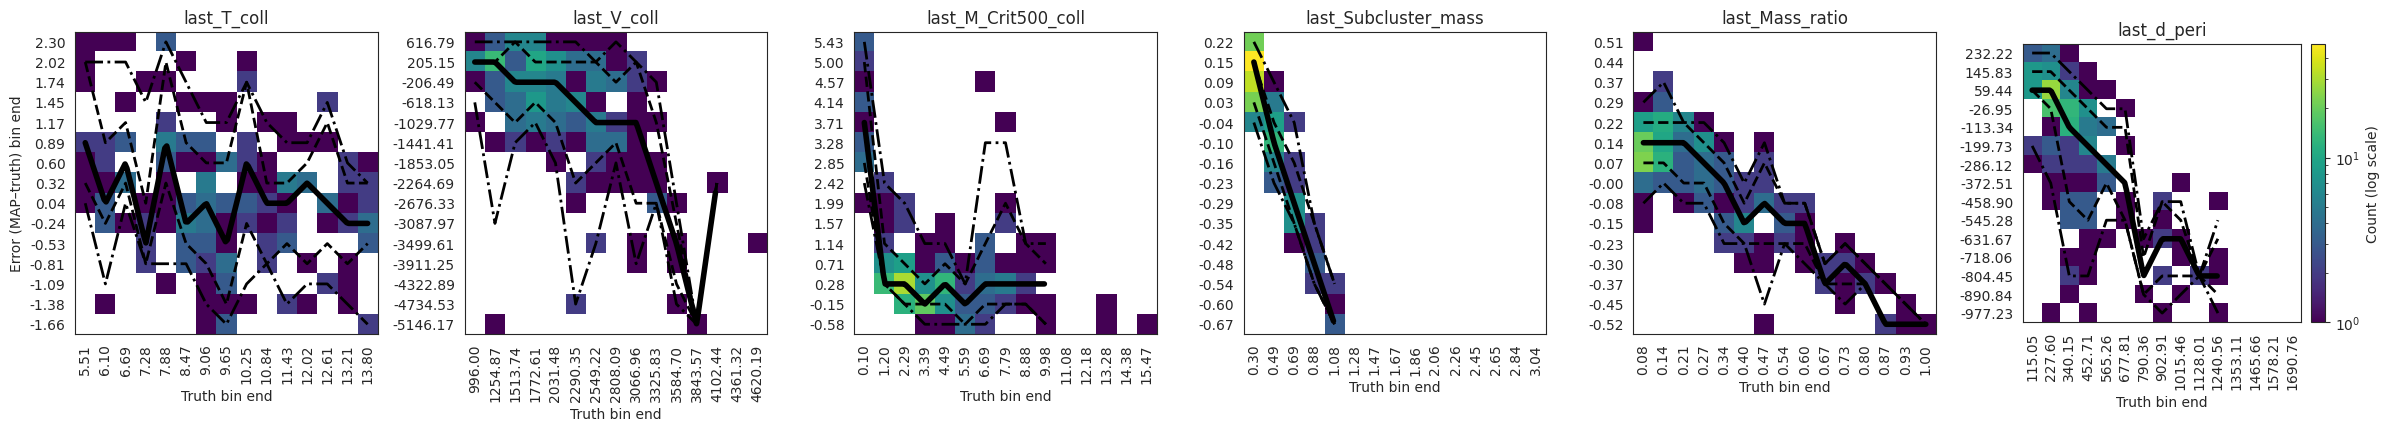

In [55]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_2d_hist(model_checkpoint: str,
                                    processed_dir: str = "processed_data",
                                    n_posterior_samples: int = 600,
                                    num_bins: int = 10,
                                    random_state: int = 42):
    """
    For each target:
      • Compute MAP via KDE.
      • Compute error = MAP – truth.
      • Globally filter errors to the 5–95th percentile,
        then bin truth vs. those filtered errors into num_bins × num_bins.
      • Overlay thick black median error line (smoothed),
        dashed black 1σ (16–84%) and dash‐dot black 2σ (2.5–97.5%) lines.
      • Plot all targets in one row with a viridis log‐scaled colorbar,
        and use y‐axis bins based on that global filtered range.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test    = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) prepare 2D hist + percentiles using global 5–95% filter
    all_data = []
    stats    = []
    for d in range(D_tar):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # compute global 5th/95th percentiles of error
        p5_gl, p95_gl = np.percentile(error, [3, 97])
        mask_gl = (error >= p5_gl) & (error <= p95_gl)

        # define bins
        tmin, tmax = truth.min(), truth.max()
        emin, emax = error[mask_gl].min(), error[mask_gl].max()
        tbins = np.linspace(tmin, tmax, num_bins + 1)
        ebins = np.linspace(emin, emax, num_bins + 1)

        # digitize truth
        t_idx = np.digitize(truth, tbins[1:-1], right=False)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.full(num_bins, np.nan)
        lo1_i  = np.full(num_bins, np.nan)
        hi1_i  = np.full(num_bins, np.nan)
        lo2_i  = np.full(num_bins, np.nan)
        hi2_i  = np.full(num_bins, np.nan)

        # per-truth-bin histogram and stats on filtered errors
        for b in range(num_bins):
            mask_b = (t_idx == b) & mask_gl
            errs_f = error[mask_b]
            if errs_f.size:
                counts[b], _ = np.histogram(errs_f, bins=ebins)

                med   = np.median(errs_f)
                lo1, hi1 = np.percentile(errs_f, [16, 84])
                lo2, hi2 = np.percentile(errs_f, [2.5, 97.5])

                med_i[b]  = np.clip(np.digitize(med, ebins) - 1, 0, num_bins - 1)
                lo1_i[b]  = np.clip(np.digitize(lo1, ebins) - 1, 0, num_bins - 1)
                hi1_i[b]  = np.clip(np.digitize(hi1, ebins) - 1, 0, num_bins - 1)
                lo2_i[b]  = np.clip(np.digitize(lo2, ebins) - 1, 0, num_bins - 1)
                hi2_i[b]  = np.clip(np.digitize(hi2, ebins) - 1, 0, num_bins - 1)

        all_data.append(counts.T)
        stats.append((med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins))

    # 6) shared log‐norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x_bins   = np.arange(num_bins)
    x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)

    for d, ax in enumerate(axes[0]):
        data, (med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins) = all_data[d], stats[d]
        t_ends = tbins[1:]
        e_ends = ebins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # median (smoothed, thick black)
        med_s = np.interp(x_smooth, x_bins, med_i)
        ax.plot(x_smooth, med_s, '-', linewidth=4, color='black')

        # dashed 1σ
        ax.plot(x_bins, lo1_i, '--', linewidth=2, color='black')
        ax.plot(x_bins, hi1_i, '--', linewidth=2, color='black')

        # dash‐dot 2σ
        ax.plot(x_bins, lo2_i, '-.', linewidth=2, color='black')
        ax.plot(x_bins, hi2_i, '-.', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin end')
        if d == 0:
            ax.set_ylabel('Error (MAP–truth) bin end')

        ax.set_xticks(x_bins)
        ax.set_xticklabels([f'{v:.2f}' for v in t_ends], rotation=90)
        ax.set_yticks(x_bins)
        ax.set_yticklabels([f'{v:.2f}' for v in e_ends])

    # colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Count (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=15,
        random_state=42
    )


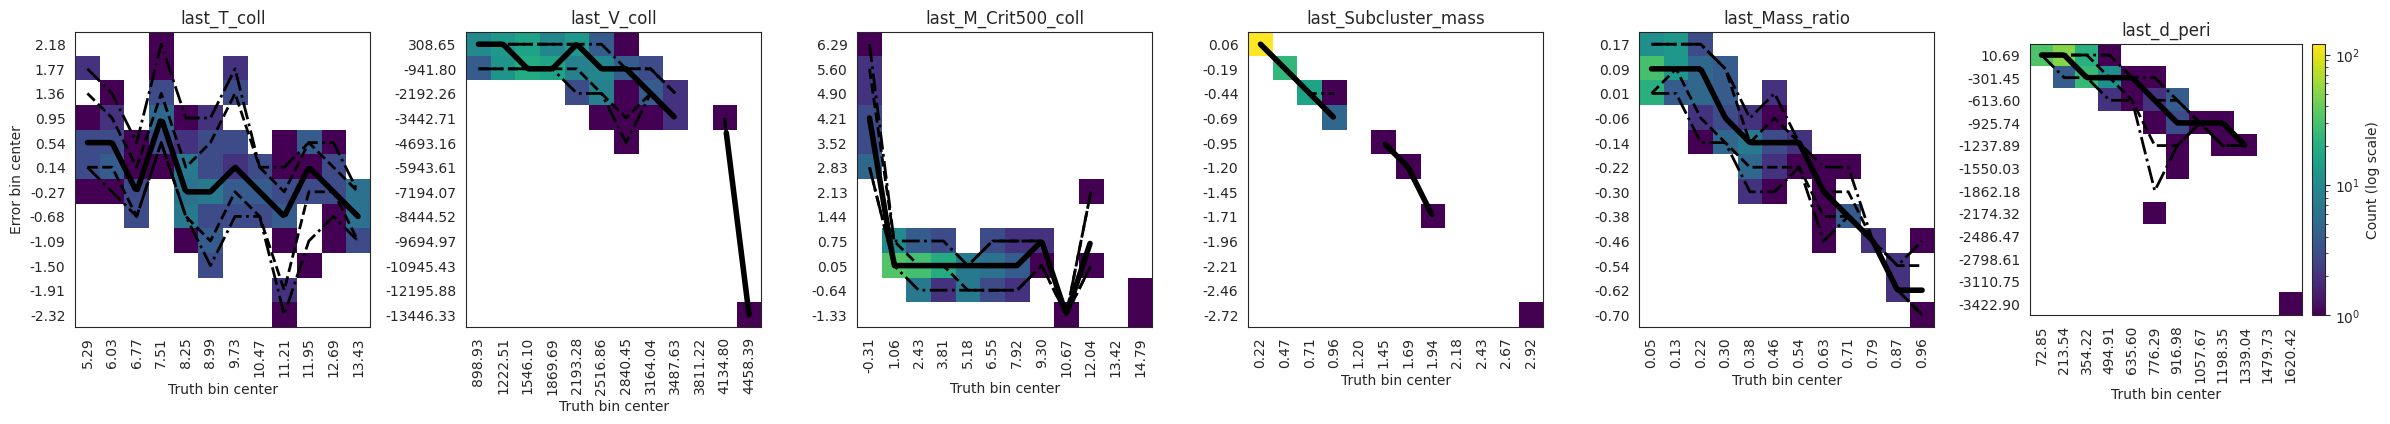

In [78]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_2d_hist(model_checkpoint: str,
                                    processed_dir: str = "processed_data",
                                    n_posterior_samples: int = 600,
                                    num_bins: int = 10,
                                    random_state: int = 42):
    """
    For each target:
      • Compute MAP via KDE.
      • Compute error = MAP – truth.
      • Bin by truth into num_bins.
      • In each truth-bin, keep errors between that bin’s 5th–95th percentile
        (or all if only one), then use the union of those filtered errors
        to define the error‐axis bins.
      • Build 2D histogram (truth-bin × error-bin) and overlay:
         – thick black median line (smoothed in bin-index space)
         – dashed black 1σ (16–84%) and dash-dot black 2σ (2.5–97.5%) lines.
      • Plot all targets in one row with a viridis log‐scaled colorbar.
    """
    # 1) Load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) Test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)

    # 3) Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) Compute MAPs
    N_test    = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) Build histograms & compute bin‐indices of percentiles
    all_data = []
    stats    = []

    for d in range(D_tar):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # truth‐axis bins (same for every target)
        tbins = np.linspace(truth.min(), truth.max(), num_bins + 1)
        t_idx = np.digitize(truth, tbins[1:-1], right=False)

        # collect filtered errors per bin & compute percentiles in index space
        filtered = []
        med_idx = np.full(num_bins, np.nan)
        lo1_idx = np.full(num_bins, np.nan)
        hi1_idx = np.full(num_bins, np.nan)
        lo2_idx = np.full(num_bins, np.nan)
        hi2_idx = np.full(num_bins, np.nan)

        for b in range(num_bins):
            errs = error[t_idx == b]
            if errs.size:
                p5, p95 = np.percentile(errs, [10,90])
                errs_f = errs[(errs >= p5) & (errs <= p95)]
                if errs_f.size == 0:
                    errs_f = errs  # keep the single point
                filtered.append(errs_f)
            else:
                filtered.append(np.array([]))

        # define global error bins from union of filtered
        union = np.concatenate([e for e in filtered if e.size])
        if union.size:
            ebins = np.linspace(union.min(), union.max(), num_bins + 1)
        else:
            ebins = np.linspace(error.min(), error.max(), num_bins + 1)

        # histogram + percentile‐bin indices
        counts = np.zeros((num_bins, num_bins), dtype=int)
        for b in range(num_bins):
            errs_f = filtered[b]
            if errs_f.size:
                counts[b], _ = np.histogram(errs_f, bins=ebins)

                # find which error‐bin each percentile lies in
                med_val = np.median(errs_f)
                lo1_val, hi1_val = np.percentile(errs_f, [16, 84])
                lo2_val, hi2_val = np.percentile(errs_f, [2.5, 97.5])

                # bin‐indices
                med_idx[b] = np.clip(np.digitize(med_val, ebins) - 1, 0, num_bins - 1)
                lo1_idx[b] = np.clip(np.digitize(lo1_val, ebins) - 1, 0, num_bins - 1)
                hi1_idx[b] = np.clip(np.digitize(hi1_val, ebins) - 1, 0, num_bins - 1)
                lo2_idx[b] = np.clip(np.digitize(lo2_val, ebins) - 1, 0, num_bins - 1)
                hi2_idx[b] = np.clip(np.digitize(hi2_val, ebins) - 1, 0, num_bins - 1)
            # else they remain nan

        all_data.append(counts.T)
        stats.append((med_idx, lo1_idx, hi1_idx, lo2_idx, hi2_idx, tbins, ebins))

    # 6) Shared log‐norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) Plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x_bins   = np.arange(num_bins)
    x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)

    for d, ax in enumerate(axes[0]):
        data, (med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins) = all_data[d], stats[d]
        t_centers = 0.5 * (tbins[:-1] + tbins[1:])
        e_centers = 0.5 * (ebins[:-1] + ebins[1:])

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # median (smoothed in bin‐index coordinates)
        med_s = np.interp(x_smooth, x_bins, med_i)
        ax.plot(x_smooth, med_s, '-', linewidth=4, color='black')

        # 1σ region
        ax.plot(x_bins, lo1_i, '--', linewidth=2, color='black')
        ax.plot(x_bins, hi1_i, '--', linewidth=2, color='black')

        # 2σ region
        ax.plot(x_bins, lo2_i, '-.', linewidth=2, color='black')
        ax.plot(x_bins, hi2_i, '-.', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin center')
        if d == 0:
            ax.set_ylabel('Error bin center')

        ax.set_xticks(x_bins)
        ax.set_xticklabels([f'{c:.2f}' for c in t_centers], rotation=90)
        ax.set_yticks(x_bins)
        ax.set_yticklabels([f'{c:.2f}' for c in e_centers])

    # Shared colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Count (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=12,
        random_state=42
    )


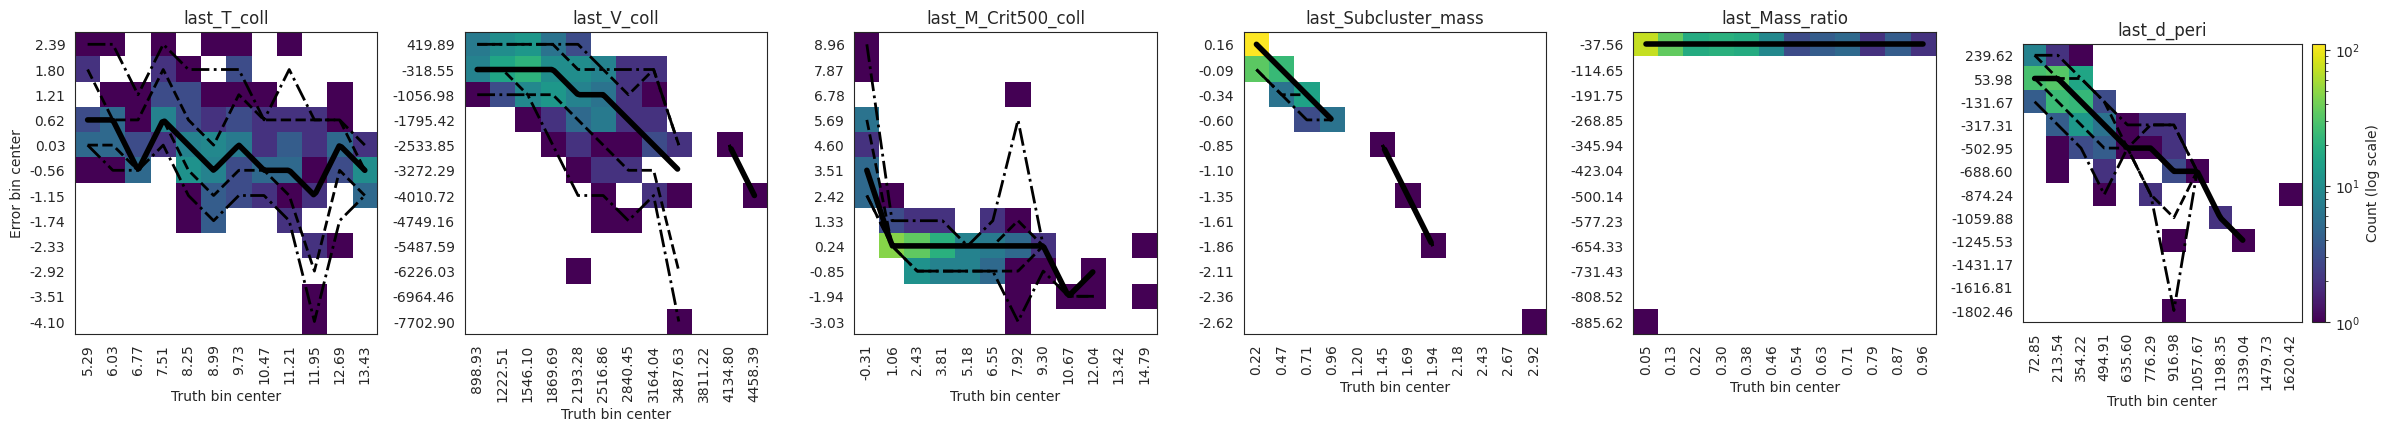

In [86]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_2d_hist(model_checkpoint: str,
                                    processed_dir: str = "processed_data",
                                    n_posterior_samples: int = 600,
                                    num_bins: int = 10,
                                    random_state: int = 42):
    """
    For each target:
      • Compute MAP via KDE.
      • Compute error = MAP – truth.
      • Bin by truth into num_bins.
      • In each truth-bin, keep errors between that bin’s 5th–95th percentile
        (or all if only one), then use the union of those filtered errors
        to define the error‐axis bins.
      • Build 2D histogram (truth-bin × error-bin) and overlay:
         – thick black median line (smoothed in bin-index space)
         – dashed black 1σ (16–84%) and dash-dot black 2σ (2.5–97.5%) lines.
      • Plot all targets in one row with a viridis log‐scaled colorbar.
    """
    # 1) Load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) Test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)

    # 3) Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) Compute MAPs
    N_test    = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) Build histograms & compute bin‐indices of percentiles
    all_data = []
    stats    = []

    for d in range(D_tar):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # truth‐axis bins (same for every target)
        tbins = np.linspace(truth.min(), truth.max(), num_bins + 1)
        t_idx = np.digitize(truth, tbins[1:-1], right=False)

        # collect filtered errors per bin & compute percentiles in index space
        filtered = []
        med_idx = np.full(num_bins, np.nan)
        lo1_idx = np.full(num_bins, np.nan)
        hi1_idx = np.full(num_bins, np.nan)
        lo2_idx = np.full(num_bins, np.nan)
        hi2_idx = np.full(num_bins, np.nan)

        for b in range(num_bins):
            errs = error[t_idx == b]
            if errs.size:
                p5, p95 = np.percentile(errs, [2,98])
                errs_f = errs[(errs >= p5) & (errs <= p95)]
                if errs_f.size == 0:
                    errs_f = errs  # keep the single point
                filtered.append(errs_f)
            else:
                filtered.append(np.array([]))

        # define global error bins from union of filtered
        union = np.concatenate([e for e in filtered if e.size])
        if union.size:
            ebins = np.linspace(union.min(), union.max(), num_bins + 1)
        else:
            ebins = np.linspace(error.min(), error.max(), num_bins + 1)

        # histogram + percentile‐bin indices
        counts = np.zeros((num_bins, num_bins), dtype=int)
        for b in range(num_bins):
            errs_f = filtered[b]
            if errs_f.size:
                counts[b], _ = np.histogram(errs_f, bins=ebins)

                # find which error‐bin each percentile lies in
                med_val = np.median(errs_f)
                lo1_val, hi1_val = np.percentile(errs_f, [16, 84])
                lo2_val, hi2_val = np.percentile(errs_f, [2.5, 97.5])

                # bin‐indices
                med_idx[b] = np.clip(np.digitize(med_val, ebins) - 1, 0, num_bins - 1)
                lo1_idx[b] = np.clip(np.digitize(lo1_val, ebins) - 1, 0, num_bins - 1)
                hi1_idx[b] = np.clip(np.digitize(hi1_val, ebins) - 1, 0, num_bins - 1)
                lo2_idx[b] = np.clip(np.digitize(lo2_val, ebins) - 1, 0, num_bins - 1)
                hi2_idx[b] = np.clip(np.digitize(hi2_val, ebins) - 1, 0, num_bins - 1)
            # else they remain nan

        all_data.append(counts.T)
        stats.append((med_idx, lo1_idx, hi1_idx, lo2_idx, hi2_idx, tbins, ebins))

    # 6) Shared log‐norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) Plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    x_bins   = np.arange(num_bins)
    x_smooth = np.linspace(0, num_bins - 1, num_bins * 10)

    for d, ax in enumerate(axes[0]):
        data, (med_i, lo1_i, hi1_i, lo2_i, hi2_i, tbins, ebins) = all_data[d], stats[d]
        t_centers = 0.5 * (tbins[:-1] + tbins[1:])
        e_centers = 0.5 * (ebins[:-1] + ebins[1:])

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # median (smoothed in bin‐index coordinates)
        med_s = np.interp(x_smooth, x_bins, med_i)
        ax.plot(x_smooth, med_s, '-', linewidth=4, color='black')

        # 1σ region
        ax.plot(x_bins, lo1_i, '--', linewidth=2, color='black')
        ax.plot(x_bins, hi1_i, '--', linewidth=2, color='black')

        # 2σ region
        ax.plot(x_bins, lo2_i, '-.', linewidth=2, color='black')
        ax.plot(x_bins, hi2_i, '-.', linewidth=2, color='black')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin center')
        if d == 0:
            ax.set_ylabel('Error bin center')

        ax.set_xticks(x_bins)
        ax.set_xticklabels([f'{c:.2f}' for c in t_centers], rotation=90)
        ax.set_yticks(x_bins)
        ax.set_yticklabels([f'{c:.2f}' for c in e_centers])

    # Shared colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Count (log scale)')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=12,
        random_state=42
    )


In [3]:
import seaborn as sns
sns.set_style('white')

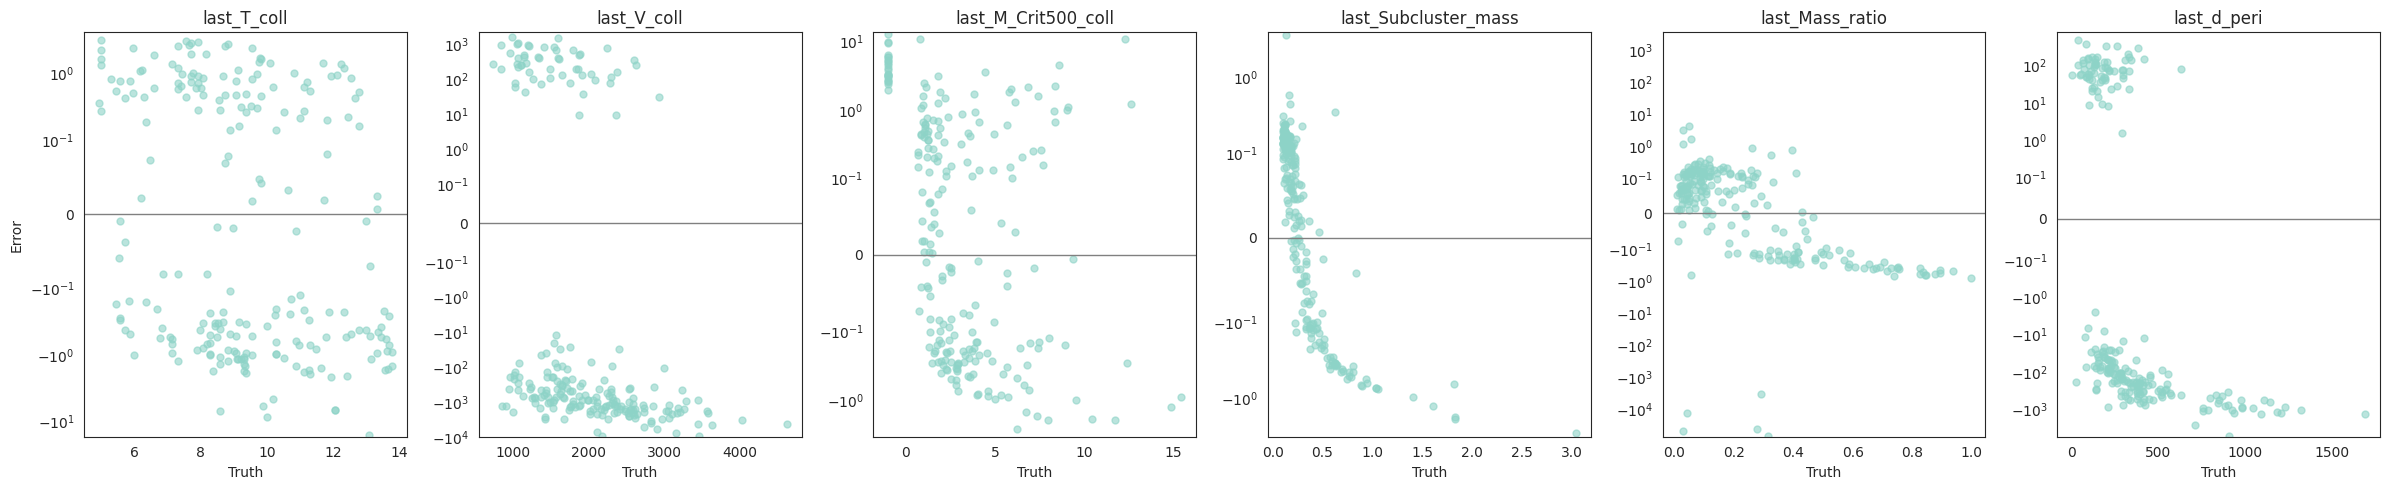

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    random_state: int = 42,
    symlog_linethresh: float = 0.1
):
    """
    For each target:
      • Compute MAP via KDE on n_posterior_samples per test galaxy.
      • Compute error = MAP - truth.
      • Scatter plot (truth vs. error).
      • Use symlog scale on error axis to compress outliers.
      • Plot all targets in one row.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) plot scatter with symlog for outliers
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # scatter
        ax.scatter(truth, error, s=25, alpha=0.6)
        ax.axhline(0, color='gray', linewidth=1)

        # set titles and labels
        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth')
        if d == 0:
            ax.set_ylabel('Error')

        # symlog on error axis to compress outliers
        ax.set_yscale('symlog', linthresh=symlog_linethresh, linscale=1.0)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        random_state=42,
        symlog_linethresh=0.1
    )


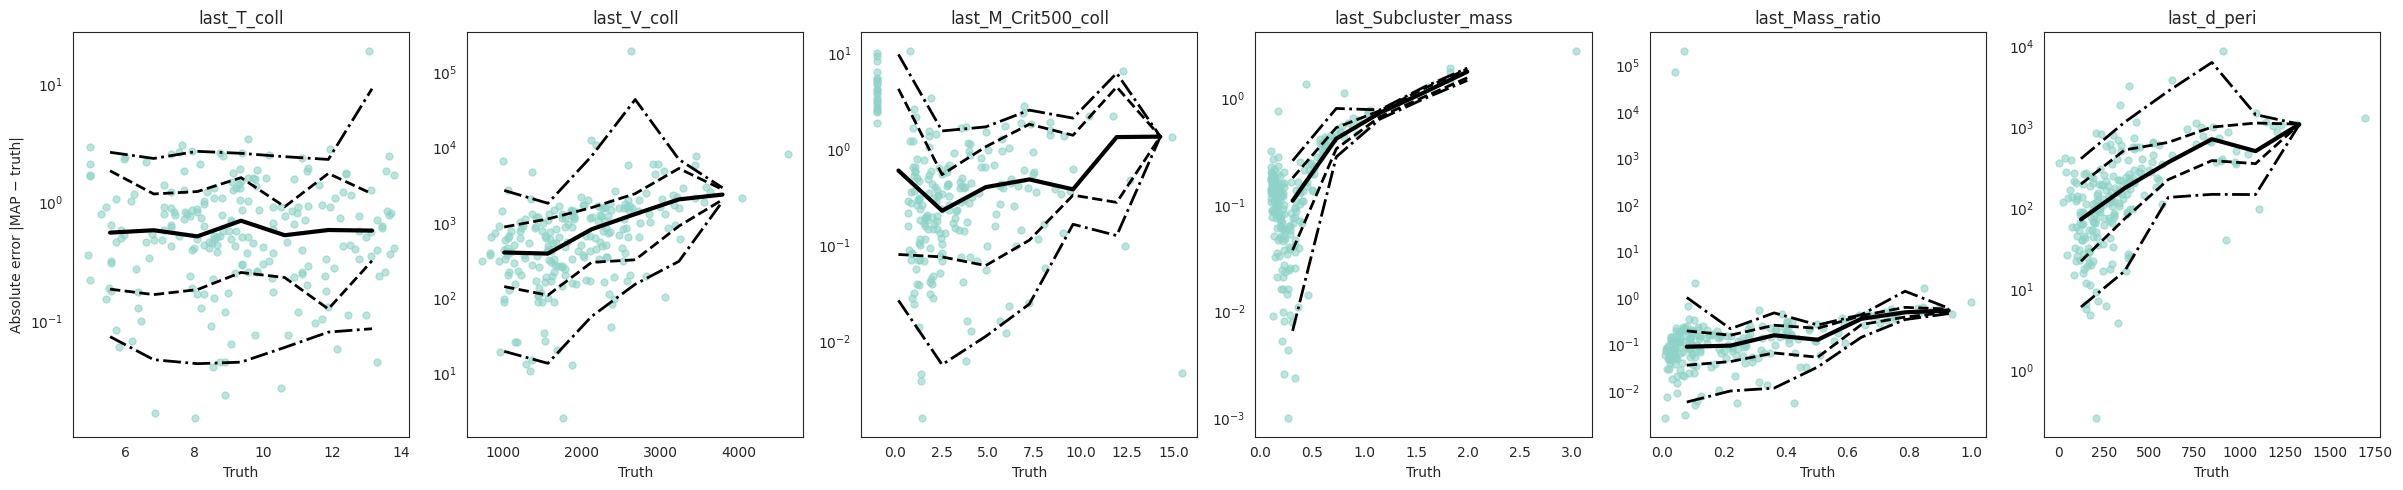

In [11]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_log(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    random_state: int = 42,
    eps: float = 1e-8
):
    """
    For each target:
      • Compute MAP via KDE on n_posterior_samples per test galaxy.
      • Compute absolute error = |MAP − truth|.
      • Scatter truth vs. abs(error) (with a tiny eps floor).
      • Bin truth into num_bins; in each bin compute:
          – median (solid black line),
          – 16th & 84th percentiles (dashed lines, ~68%),
          – 2.5th & 97.5th percentiles (dash-dot lines, ~95%).
      • Set the y-axis to pure log scale.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) plotting
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    axes = axes[0]

    for d, ax in enumerate(axes):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth
        err_mag = np.abs(error) + eps  # floor to avoid zeros on log scale

        # scatter points
        ax.scatter(truth, err_mag, s=25, alpha=0.6)
        ax.set_yscale("log")
        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel("Truth")
        if d == 0:
            ax.set_ylabel("Absolute error |MAP − truth|")

        # bin ground truth
        bins = np.linspace(truth.min(), truth.max(), num_bins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1  # bins 0..num_bins-1

        # prepare percentile arrays
        med  = np.full(num_bins, np.nan)
        lo1  = np.full(num_bins, np.nan)
        hi1  = np.full(num_bins, np.nan)
        lo2  = np.full(num_bins, np.nan)
        hi2  = np.full(num_bins, np.nan)

        # compute percentiles per bin (on err_mag)
        for i_bin in range(num_bins):
            sel = err_mag[inds == i_bin]
            if sel.size > 0:
                med[i_bin] = np.median(sel)
                lo1[i_bin], hi1[i_bin] = np.percentile(sel, [16, 84])
                lo2[i_bin], hi2[i_bin] = np.percentile(sel, [2.5, 97.5])

        # overlay percentile lines
        ax.plot(bin_centers, med, '-',  linewidth=3, color='black')
        ax.plot(bin_centers, lo1, '--', linewidth=2, color='black')
        ax.plot(bin_centers, hi1, '--', linewidth=2, color='black')
        ax.plot(bin_centers, lo2, '-.', linewidth=2, color='black')
        ax.plot(bin_centers, hi2, '-.', linewidth=2, color='black')

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_log(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=7,
        random_state=42
    )


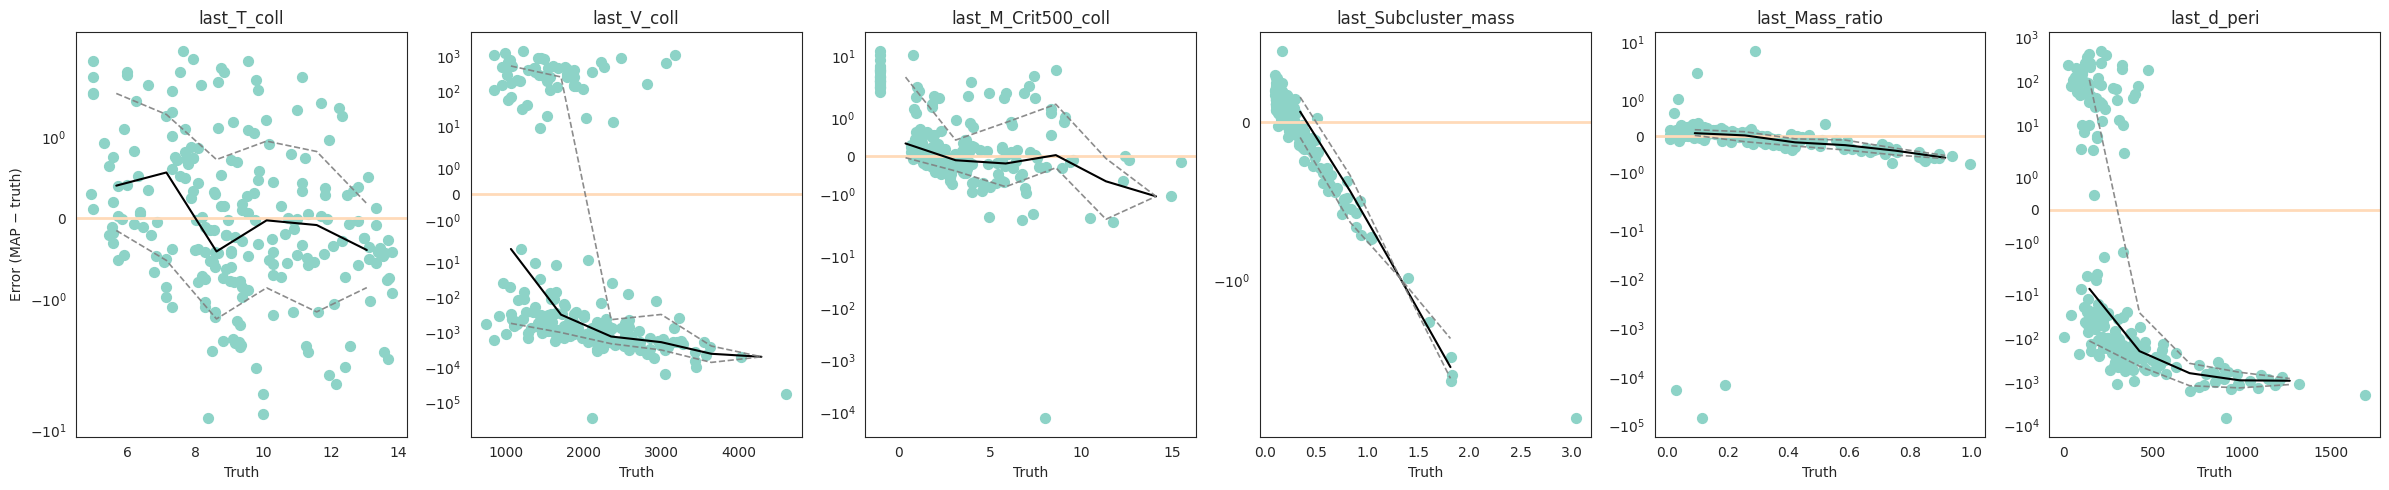

In [45]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_error_vs_truth_symlog(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh: float = 0.1,
    random_state: int = 42
):
    """
    For each target:
      • Compute MAP via KDE on n_posterior_samples per test galaxy.
      • Compute signed error = MAP − truth.
      • Scatter truth vs. error (larger opaque dots).
      • Bin truth into num_bins; in each bin compute:
          – median (solid gray line),
          – 16th & 84th percentiles (dashed gray lines, ~68%),
          – 2.5th & 97.5th percentiles (dash-dot gray lines, ~95%).
      • Use symmetric‐log scaling on the error axis so zero is visible.
      • Draw a peach-pink horizontal line at zero.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) plotting
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    axes = axes[0]

    for d, ax in enumerate(axes):
        truth = true_phys[:, d]
        error = maps_phys[:, d] - truth

        # scatter: larger, fully opaque dots
        ax.scatter(truth, error, s=50, alpha=1.0)

        # peach-pink zero line
        ax.axhline(0, color='peachpuff', linewidth=2)

        # bin ground truth
        bins = np.linspace(truth.min(), truth.max(), num_bins + 1)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1  # 0..num_bins-1

        # prepare percentile arrays
        med  = np.full(num_bins, np.nan)
        lo1  = np.full(num_bins, np.nan)
        hi1  = np.full(num_bins, np.nan)
        lo2  = np.full(num_bins, np.nan)
        hi2  = np.full(num_bins, np.nan)

        # compute percentiles per bin
        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med[i_bin] = np.median(sel)
                lo1[i_bin], hi1[i_bin] = np.percentile(sel, [16, 84])
                lo2[i_bin], hi2[i_bin] = np.percentile(sel, [2.5, 97.5])

        # overlay gray percentile lines (more opaque, thinner)
        ax.plot(bin_centers, med, '-',  linewidth=1.5, color='black',  alpha=1)
        ax.plot(bin_centers, lo1, '--', linewidth=1.2, color='gray',  alpha=0.9)
        ax.plot(bin_centers, hi1, '--', linewidth=1.2, color='gray',  alpha=0.9)
        #ax.plot(bin_centers, lo2, '-.', linewidth=1.2, color='gray',  alpha=0.9)
        #ax.plot(bin_centers, hi2, '-.', linewidth=1.2, color='gray',  alpha=0.9)

        # symmetric-log scale on error axis so zero is visible
        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel("Truth")
        if d == 0:
            ax.set_ylabel("Error (MAP − truth)")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_error_vs_truth_symlog(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=6,
        linthresh=1.5,
        random_state=42
    )


# scatter plot version of figure 15

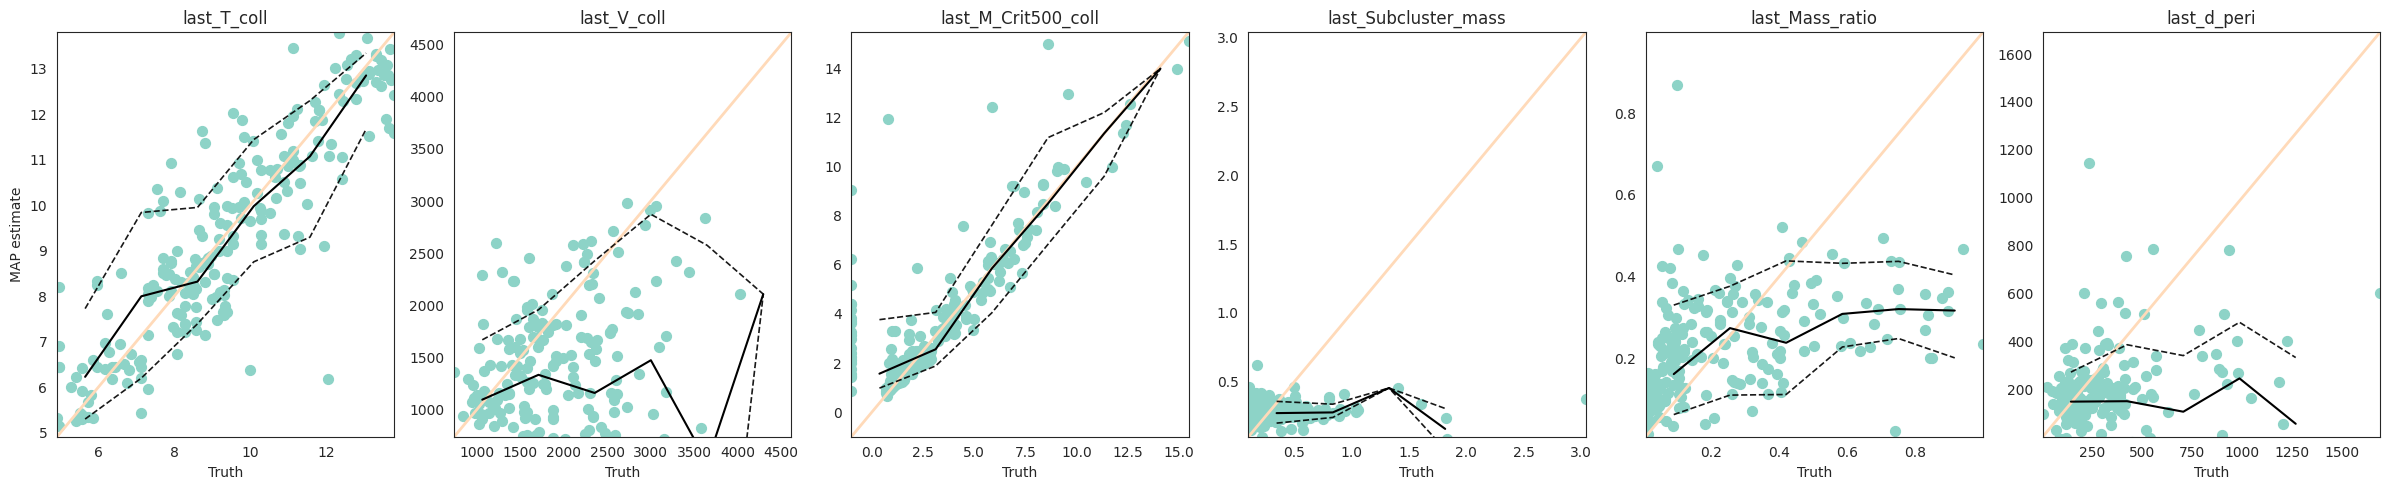

In [55]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_vs_truth_linear(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    random_state: int = 42
):
    """
    For each target:
      • Compute cINN MAP per test galaxy via KDE on n_posterior_samples.
      • Scatter truth vs. MAP with opaque markers.
      • Bin truth into num_bins; in each bin compute:
          – median MAP (solid black),
          – 10th & 90th percentiles (dashed black).
      • Draw a peach-pink 1:1 line.
      • Lock x- and y-limits to the [min(truth), max(truth)] range.
      • Use plain linear scaling on both axes.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) plotting
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    axes = axes[0]

    for d, ax in enumerate(axes):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]

        # get limits from ground-truth
        tmin, tmax = truth.min(), truth.max()

        # scatter: large opaque dots
        ax.scatter(truth, mapv, s=50, alpha=1.0)

        # peach-pink 1:1 line
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        # bin ground truth
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1  # 0..num_bins-1

        # compute percentiles per bin
        med  = np.full(num_bins, np.nan)
        lo   = np.full(num_bins, np.nan)
        hi   = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = mapv[inds == i_bin]
            if sel.size > 0:
                med[i_bin] = np.median(sel)
                lo[i_bin], hi[i_bin] = np.percentile(sel, [10, 90])

        # overlay black percentile lines
        ax.plot(centers, med, '-',  linewidth=1.5, color='black', alpha=1.0)
        ax.plot(centers, lo,  '--', linewidth=1.2, color='black', alpha=0.9)
        ax.plot(centers, hi,  '--', linewidth=1.2, color='black', alpha=0.9)

        # lock both axes to truth range (linear scale)
        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel("Truth")
        if d == 0:
            ax.set_ylabel("MAP estimate")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_vs_truth_linear(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=6,
        random_state=42
    )


# scatter plot 15.2, 15.3

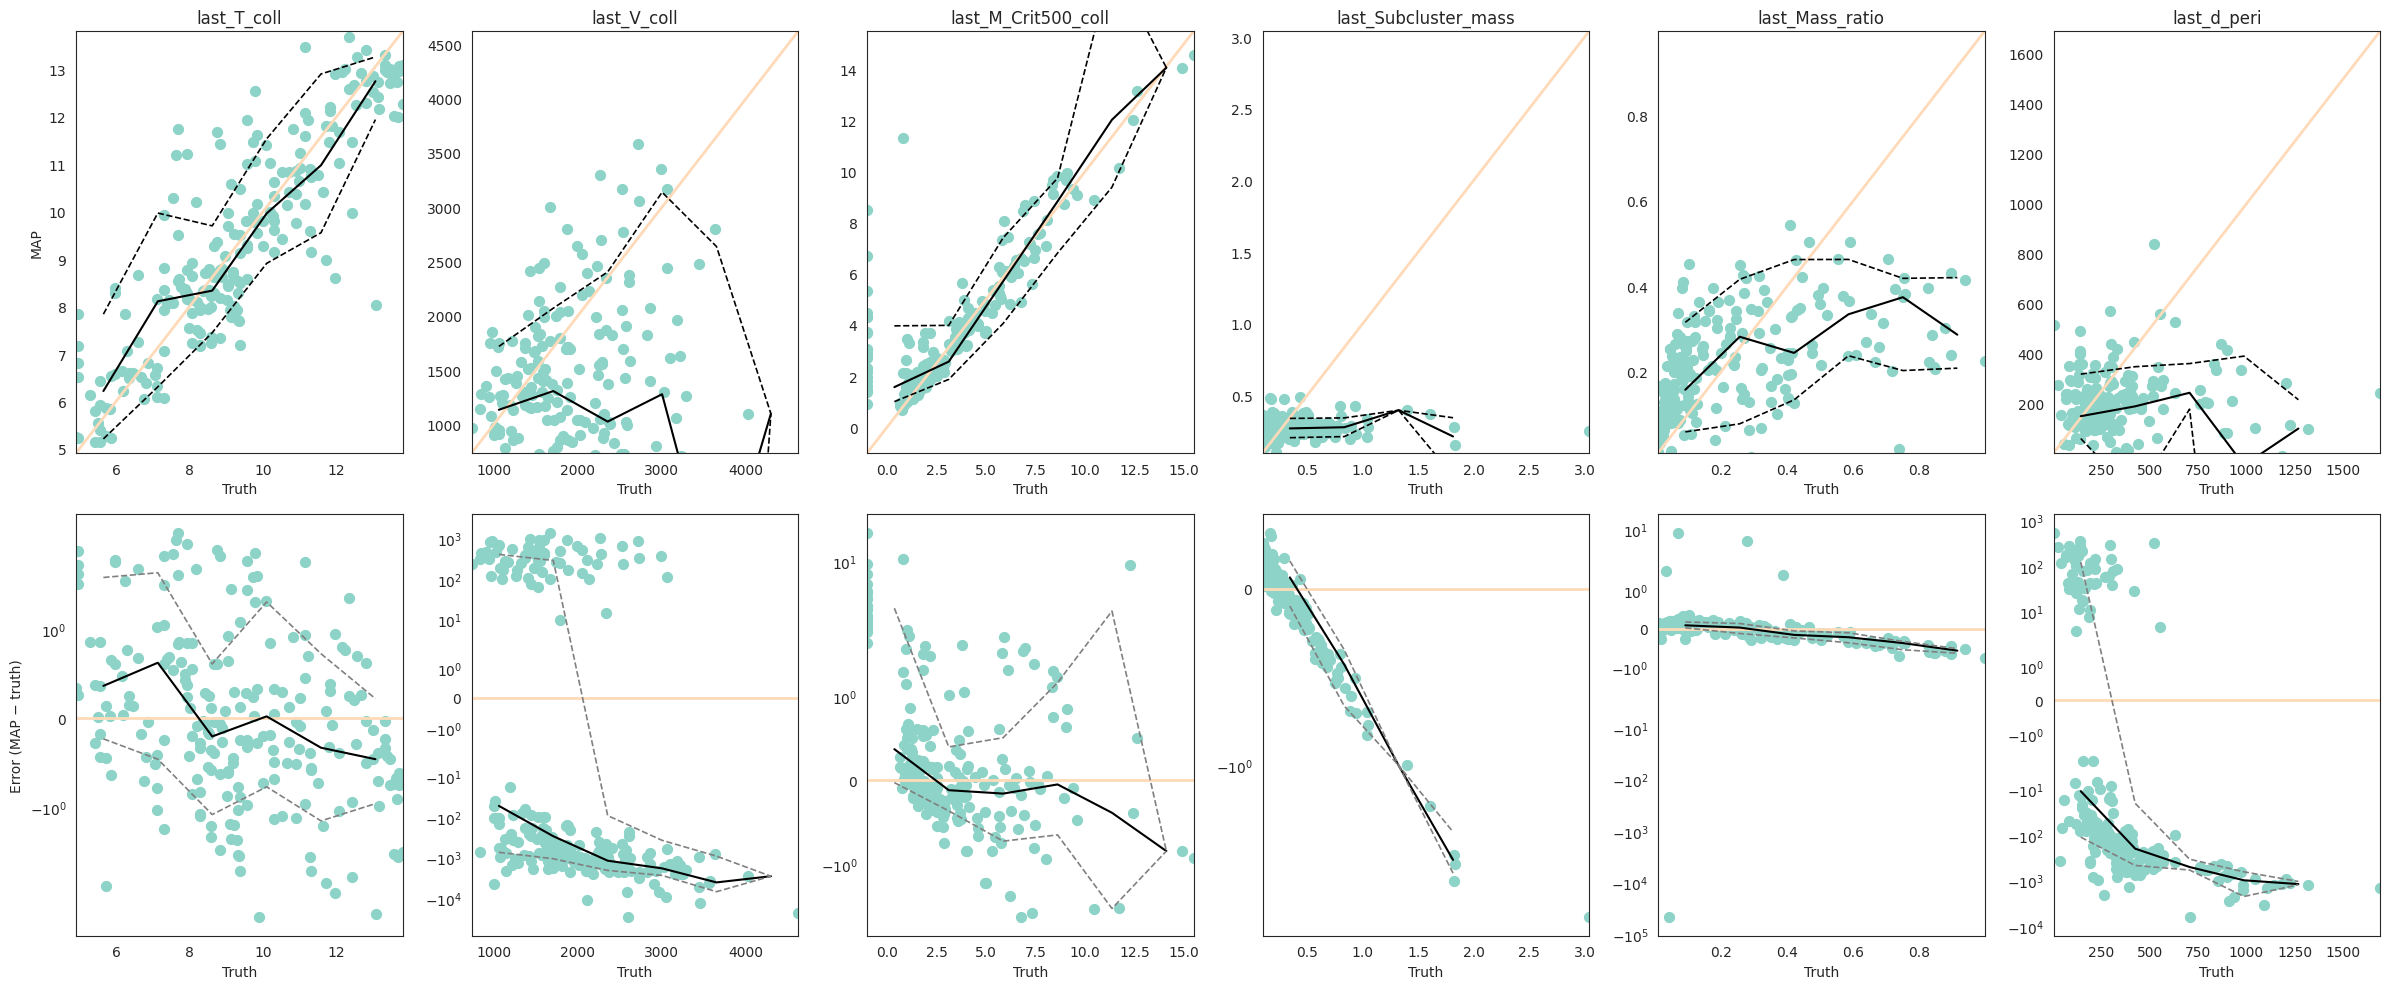

In [56]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh: float = 0.1,
    random_state: int = 42
):
    """
    Top row:    truth vs MAP (linear y), with percentile bands
    Bottom row: truth vs error (symlog y), with percentile bands
    Both rows:  scatter + bin‐wise medians (solid) & percentiles (dashed).
    X‐limits locked to [min(truth), max(truth)] for each target.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) set up figure: 2 rows × D_tar columns
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    # loop over targets
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        error = mapv - truth

        # common x‐limits from truth
        tmin, tmax = truth.min(), truth.max()

        # ==== Top: truth vs MAP ====
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=50, alpha=1.0)
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        # bin and compute percentiles for MAP
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1

        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = mapv[inds == i_bin]
            if sel.size > 0:
                med_map[i_bin] = np.median(sel)
                lo_map[i_bin], hi_map[i_bin] = np.percentile(sel, [10, 90])

        ax.plot(centers, med_map, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo_map,  '--', linewidth=1.2, color='black')
        ax.plot(centers, hi_map,  '--', linewidth=1.2, color='black')

        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)
        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel("Truth")
        if d == 0:
            ax.set_ylabel("MAP")

        # ==== Bottom: truth vs error ====
        ax = axes[1, d]
        ax.scatter(truth, error, s=50, alpha=1.0)
        ax.axhline(0, color='peachpuff', linewidth=2)

        # bin and compute percentiles for error
        med_err = np.full(num_bins, np.nan)
        lo1_err = np.full(num_bins, np.nan)
        hi1_err = np.full(num_bins, np.nan)
        lo2_err = np.full(num_bins, np.nan)
        hi2_err = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med_err[i_bin]  = np.median(sel)
                lo1_err[i_bin], hi1_err[i_bin] = np.percentile(sel, [16, 84])
                lo2_err[i_bin], hi2_err[i_bin] = np.percentile(sel, [2.5, 97.5])

        ax.plot(centers, med_err, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo1_err, '--', linewidth=1.2, color='gray')
        ax.plot(centers, hi1_err, '--', linewidth=1.2, color='gray')
        # you can also enable the 2σ bands if desired:
        # ax.plot(centers, lo2_err, '-.', linewidth=1.2, color='gray')
        # ax.plot(centers, hi2_err, '-.', linewidth=1.2, color='gray')

        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)
        ax.set_xlim(tmin, tmax)
        ax.set_xlabel("Truth")
        if d == 0:
            ax.set_ylabel("Error (MAP − truth)")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_and_error_vs_truth(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=6,
        linthresh=1.5,
        random_state=42
    )


# final scatter plot of 15.2, 15.3

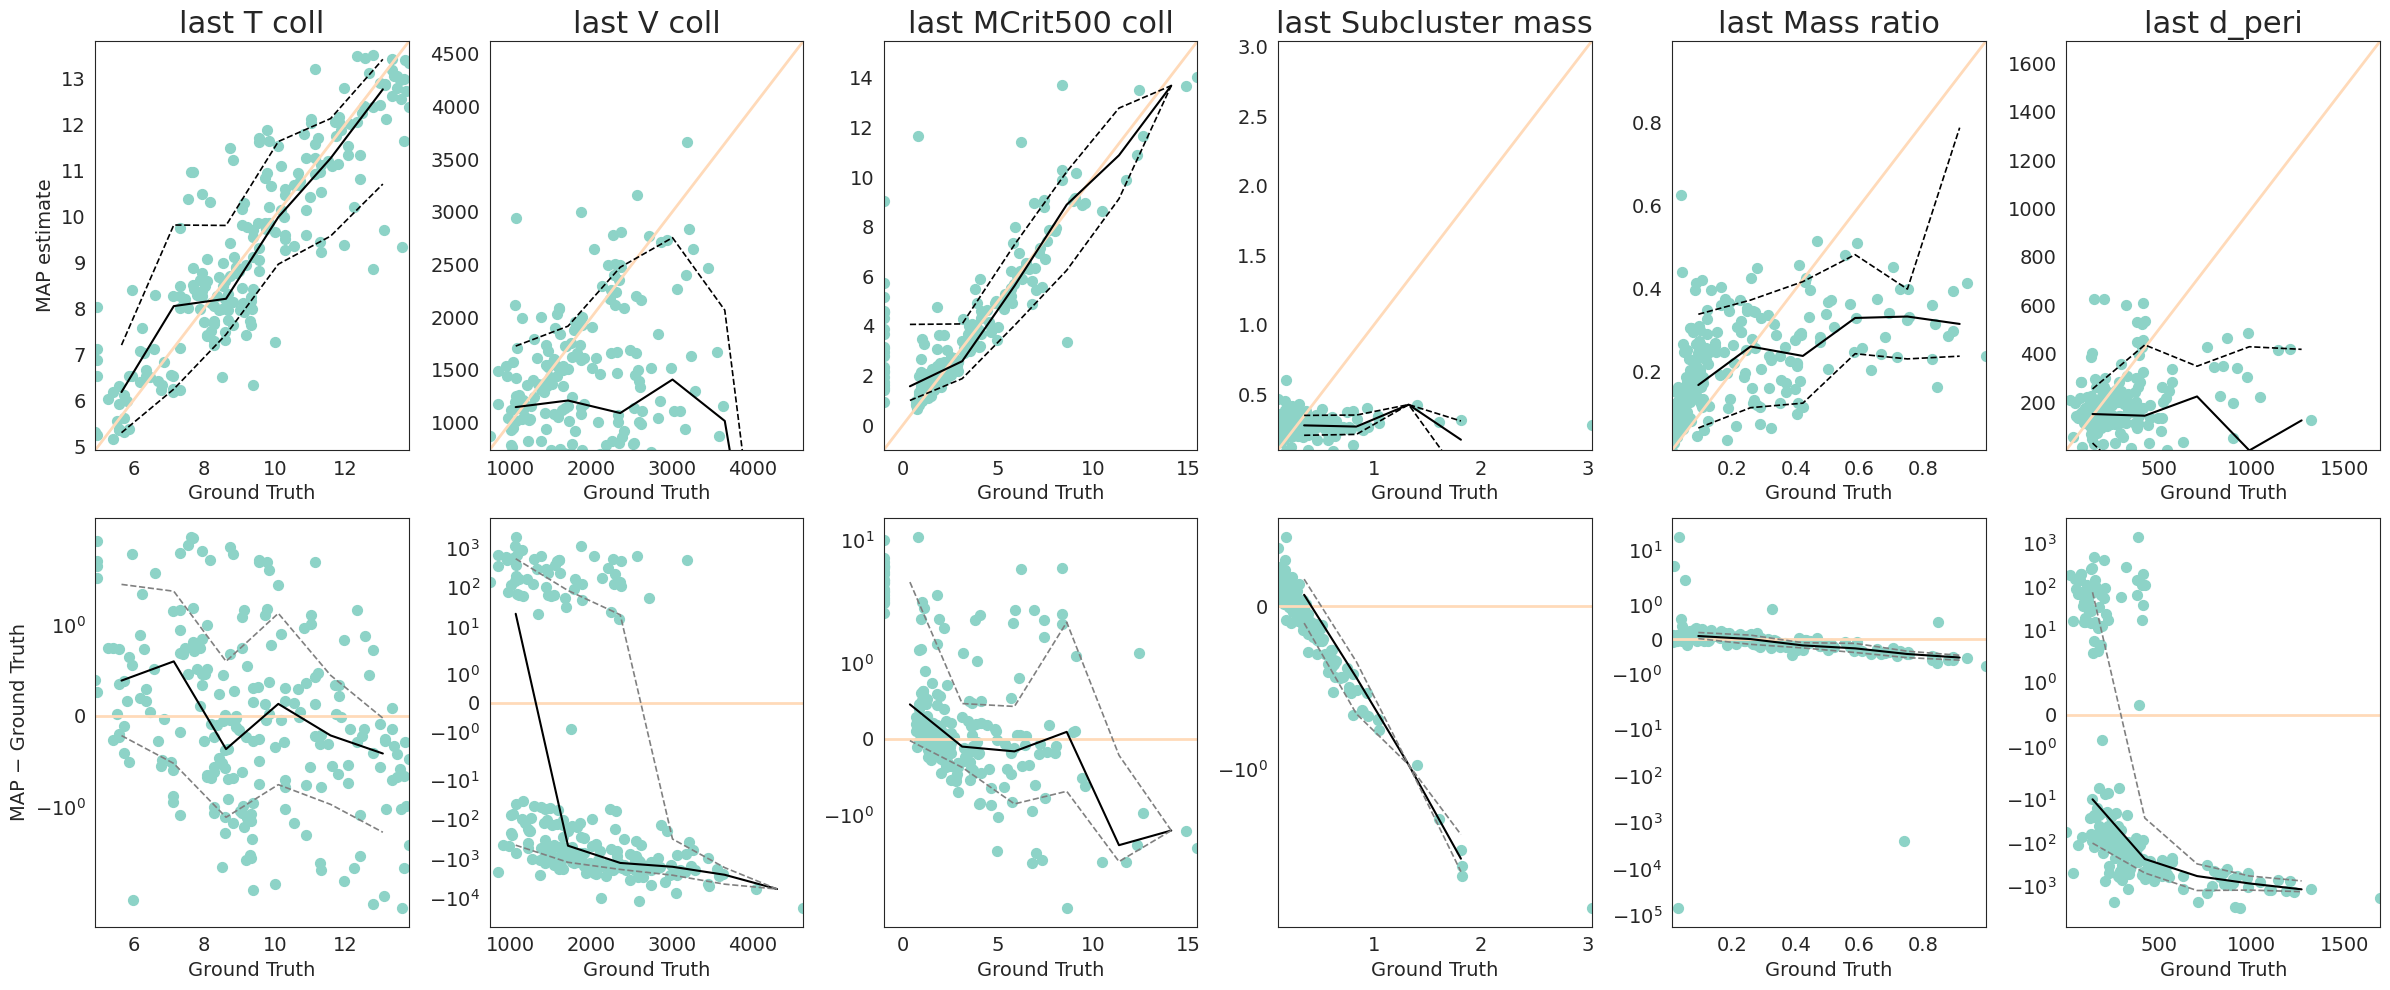

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

# your target names
TARGET_COLS = [
    'last_T_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
]

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh: float = 0.1,
    random_state: int = 42,
    label_fontsize: int = 14,
    title_fontsize: int = 22
):
    """
    Top row:    truth vs MAP (linear y), with percentile bands
    Bottom row: truth vs error (symlog y), with percentile bands
    Both rows:  scatter + bin‐wise medians (solid) & percentiles (dashed).
    X‐limits locked to [min(truth), max(truth)] for each target.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) train/test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) compute MAPs
    N_test = X_test.shape[0]
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # 5) set up figure: 2 rows × D_tar columns
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    # loop over targets
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        error = mapv - truth

        # common x‐limits from truth
        tmin, tmax = truth.min(), truth.max()

        # ==== Top: truth vs MAP ====
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=50, alpha=1.0)
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', linewidth=2)

        # bin and compute percentiles for MAP
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1

        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = mapv[inds == i_bin]
            if sel.size > 0:
                med_map[i_bin] = np.median(sel)
                lo_map[i_bin], hi_map[i_bin] = np.percentile(sel, [10, 90])

        ax.plot(centers, med_map, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo_map,  '--', linewidth=1.2, color='black')
        ax.plot(centers, hi_map,  '--', linewidth=1.2, color='black')

        ax.set_xlim(tmin, tmax)
        ax.set_ylim(tmin, tmax)
        ax.set_title(TARGET_COLS[d], fontsize=title_fontsize)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

        # ==== Bottom: truth vs error ====
        ax = axes[1, d]
        ax.scatter(truth, error, s=50, alpha=1.0)
        ax.axhline(0, color='peachpuff', linewidth=2)

        # bin and compute percentiles for error
        med_err = np.full(num_bins, np.nan)
        lo1_err = np.full(num_bins, np.nan)
        hi1_err = np.full(num_bins, np.nan)
        for i_bin in range(num_bins):
            sel = error[inds == i_bin]
            if sel.size > 0:
                med_err[i_bin]  = np.median(sel)
                lo1_err[i_bin], hi1_err[i_bin] = np.percentile(sel, [16, 84])

        ax.plot(centers, med_err, '-',  linewidth=1.5, color='black')
        ax.plot(centers, lo1_err, '--', linewidth=1.2, color='gray')
        ax.plot(centers, hi1_err, '--', linewidth=1.2, color='gray')

        ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)
        ax.set_xlim(tmin, tmax)
        ax.set_title("", fontsize=title_fontsize)  # no title on bottom
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP − Ground Truth", fontsize=label_fontsize)
        ax.tick_params(axis='both', labelsize=label_fontsize)

    # save figure as pdf and png
    fig.savefig("Fig15.2-3map_and_error_vs_truth.pdf", bbox_inches='tight')
    fig.savefig("Fig15.2-3map_and_error_vs_truth.png", bbox_inches='tight')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_map_and_error_vs_truth(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=100,
        num_bins=6,
        linthresh=1.5,
        random_state=42
    )




# final Fig 15.1

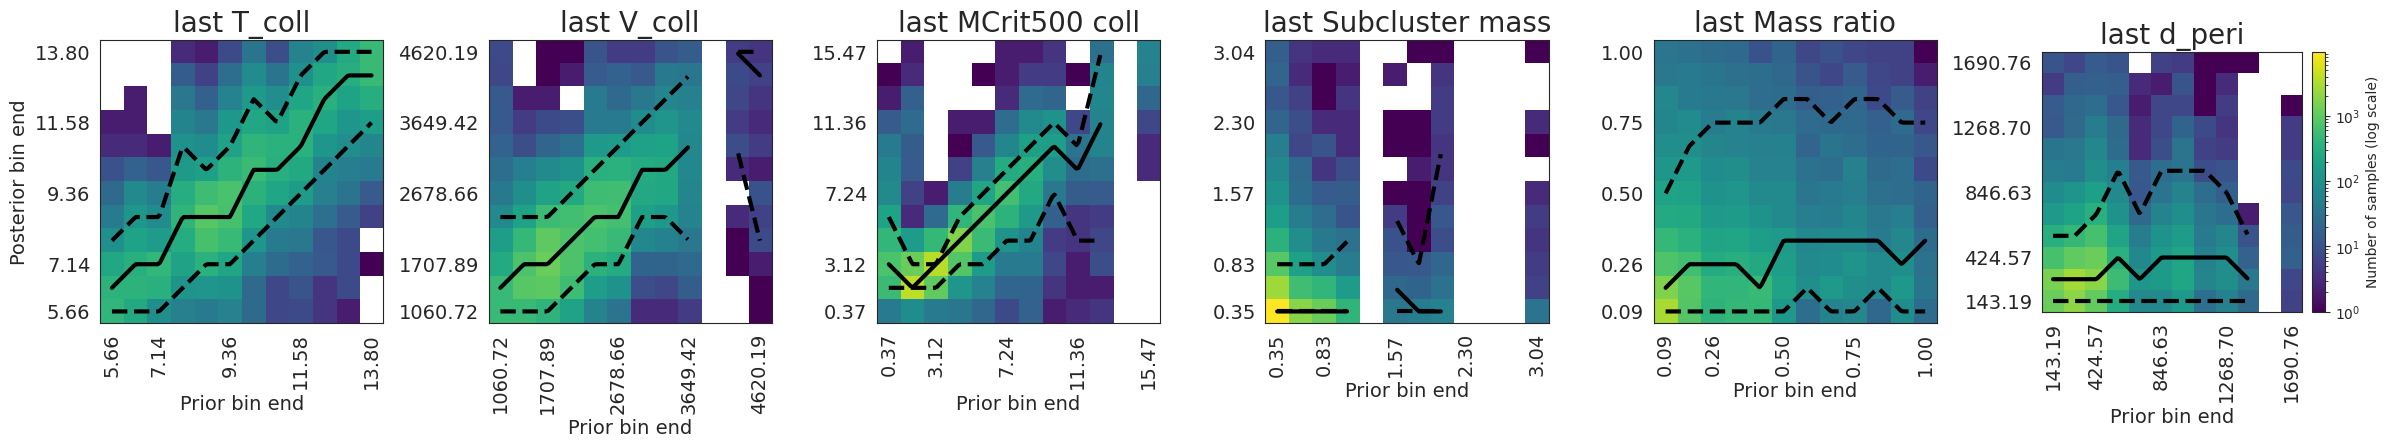

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last T_coll',
    'last V_coll',
    'last MCrit500 coll',
    'last Subcluster mass',
    'last Mass ratio',
    'last d_peri'
]

def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                n_samples_per_galaxy: int = 100,
                                random_state: int = 42,
                                num_bins: int = 10):
    """
    Plot heatmaps of prior vs posterior bin counts for each target,
    with viridis colormap, smooth & thicker median/percentile lines,
    and sparse ticks.
    """
    # --- Load data & model ---
    X_full = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y_full = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N, _    = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    idx         = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, X_test.shape[1], 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # --- Gather heatmap data for each target ---
    all_data = []
    results  = []
    for d in range(D_tar):
        gt   = tar_sc.inverse_transform(Y_test)[:, d]
        bins = np.linspace(gt.min(), gt.max(), num_bins + 1)
        bin_idx = np.digitize(gt, bins[1:-1], right=False)

        # collect posterior samples per prior-bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_galaxy, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_galaxy, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.zeros(num_bins)
        lo_i   = np.zeros(num_bins)
        hi_i   = np.zeros(num_bins)

        for b in range(num_bins):
            samples = bin_to_post[b]
            if samples:
                arr = np.concatenate(samples)
                counts[b], _ = np.histogram(arr, bins=bins)
                med_i[b] = np.clip(np.digitize(np.median(arr), bins) - 1, 0, num_bins - 1)
                lo_i[b]  = np.clip(np.digitize(np.percentile(arr, 10), bins) - 1, 0, num_bins - 1)
                hi_i[b]  = np.clip(np.digitize(np.percentile(arr, 90), bins) - 1, 0, num_bins - 1)
            else:
                med_i[b] = lo_i[b] = hi_i[b] = np.nan

        data = counts.T
        all_data.append(data)
        results.append((data, med_i, lo_i, hi_i, bins))

    # --- Shared LogNorm across all heatmaps ---
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # --- Plot row of subplots + single colorbar ---
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)

    # sparse tick positions
    max_ticks = 5
    tick_positions = np.linspace(0, num_bins - 1,
                                 min(max_ticks, num_bins)).astype(int)

    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # smooth & thicker median line
        x_bins    = np.arange(num_bins)
        x_smooth  = np.linspace(0, num_bins - 1, num_bins * 10)
        med_smooth = np.interp(x_smooth, x_bins, med_i)
        lo_smooth  = np.interp(x_smooth, x_bins, lo_i)
        hi_smooth  = np.interp(x_smooth, x_bins, hi_i)

        ax.plot(x_smooth, med_smooth,  linestyle='-', linewidth=3, color='black')
        ax.plot(x_smooth, lo_smooth,   linestyle='--', linewidth=3, color='black')
        ax.plot(x_smooth, hi_smooth,   linestyle='--', linewidth=3, color='black')

        ax.set_title(TARGET_COLS[d], fontsize=20)
        ax.set_xlabel('Prior bin end', fontsize=14)
        if d == 0:
            ax.set_ylabel('Posterior bin end', fontsize=14)

        # apply sparse ticks
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           rotation=90, fontsize=14)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels([f'{ends[i]:.2f}' for i in tick_positions],
                           fontsize=14)

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.mappable.set_cmap('viridis')
    cbar.set_label('Number of samples (log scale)')

    plt.tight_layout()

    # save figure as pdf and png
    fig.savefig("Fig15.1-posterior_vs_truth.pdf", bbox_inches='tight')
    fig.savefig("Fig15.1-posterior_vs_truth.png", bbox_inches='tight')
    plt.show()

    return results


if __name__ == "__main__":
    _ = plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_samples_per_galaxy=100,
        random_state=42,
        num_bins=12
    )


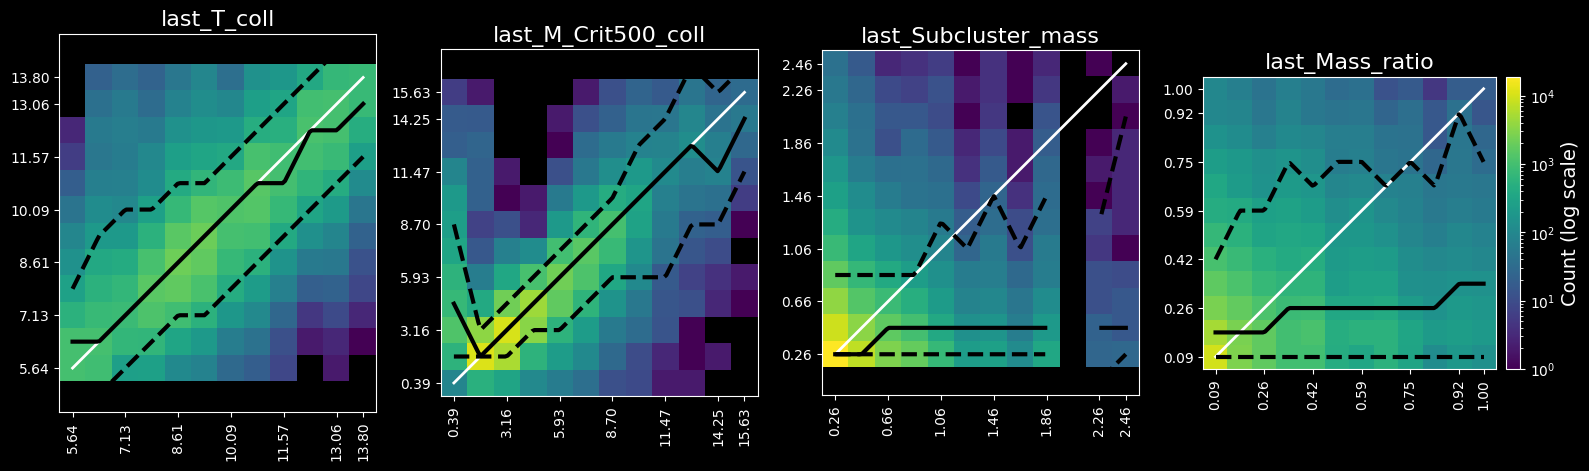

In [5]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

# This script plots prior vs posterior heatmaps for each target
# in your combined (scalar+embedding) pipeline.

def normalize_key(fname):
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
    return f"{int(m.group(2))}_{int(m.group(1))}"


def load_test_projections(processed_dir, embeddings_npy, filenames_npy,
                          random_state=42, test_frac=0.1):
    # 1) load halo-level CSVs and scalers
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values
    Y_all   = dfY.values
    key2idx = { f"{int(r.HaloID)}_{int(r.Snapshot)}": i
                for i, r in meta.iterrows() }

    # 2) load all embeddings + filenames, filter to kept halos
    all_emb   = np.load(embeddings_npy)
    all_files = np.load(filenames_npy)
    proj_keys, Es = [], []
    for fn, emb in zip(all_files, all_emb):
        key = normalize_key(fn)
        if key in key2idx:
            proj_keys.append(key)
            Es.append(emb)
    E_proj_raw = np.vstack(Es)    # (n_proj, D_emb)

    # 3) replicate scalar+target rows for each projection
    X_s_proj = np.vstack([ X_s_all[key2idx[k]] for k in proj_keys ])
    Y_proj   = np.vstack([   Y_all[key2idx[k]]   for k in proj_keys ])

    # 4) scale embeddings
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)

    # 5) combine and split
    X_all = np.hstack([X_s_proj, E_proj])
    Y_all = Y_proj
    N = X_all.shape[0]
    idx = np.arange(N)
    idx_tmp, idx_test = train_test_split(idx, test_size=test_frac, random_state=random_state)
    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    return X_test, Y_test, keys_test, dfY.columns.tolist()


def plot_posteriors_all_targets(model_checkpoint: str,
                                processed_dir: str = "processed_data",
                                embeddings_npy: str = "embeddings.npy",
                                filenames_npy: str  = "filenames.npy",
                                n_samples_per_proj: int = 100,
                                random_state: int       = 42,
                                num_bins: int           = 10,
                                max_ticks: int          = 5):
    """
    Plot heatmaps of prior vs posterior counts for each target
    in the combined pipeline.
    """
    # load test projections + column names
    X_test, Y_test, keys_test, target_names = load_test_projections(
        processed_dir, embeddings_npy, filenames_npy,
        random_state=random_state, test_frac=0.1
    )
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N_test, _ = X_test.shape
    D_tar     = Y_test.shape[1]
    # adopt targets dynamically
    assert D_tar == len(target_names)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load model
    x_dim = X_test.shape[1]
    model = cINN(y_dim=D_tar, x_dim=x_dim, hidden_dim=128, n_blocks=12, clamp=2.0)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.to(device).eval()

    # build priors/posteriors
    all_data = []
    results  = []
    Y_phys = tar_sc.inverse_transform(Y_test)
    for d in range(D_tar):
        truth = Y_phys[:, d]
        bins  = np.linspace(truth.min(), truth.max(), num_bins+1)
        bin_idx = np.digitize(truth, bins[1:-1], right=False)

        # collect posterior samples for each prior bin
        bin_to_post = {b: [] for b in range(num_bins)}
        with torch.no_grad():
            for i, b in enumerate(bin_idx):
                x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
                Z  = torch.randn(n_samples_per_proj, D_tar, device=device)
                inv = model.inverse(Z, x0.repeat(n_samples_per_proj, 1))
                Ys  = inv[0] if isinstance(inv, tuple) else inv
                phys = tar_sc.inverse_transform(Ys.cpu().numpy())[:, d]
                bin_to_post[b].append(phys)

        counts = np.zeros((num_bins, num_bins), dtype=int)
        med_i  = np.full(num_bins, np.nan)
        lo_i   = np.full(num_bins, np.nan)
        hi_i   = np.full(num_bins, np.nan)
        for b in range(num_bins):
            arrs = bin_to_post[b]
            if not arrs:
                continue
            arr = np.concatenate(arrs)
            counts[b], _ = np.histogram(arr, bins=bins)
            med_i[b] = np.digitize(np.median(arr),       bins) - 1
            lo_i[b]  = np.digitize(np.percentile(arr,10), bins) - 1
            hi_i[b]  = np.digitize(np.percentile(arr,90), bins) - 1

        all_data.append(counts.T)
        results.append((counts.T, med_i, lo_i, hi_i, bins))

    # shared LogNorm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat>0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # ticks
    step = max(1, num_bins//max_ticks)
    ticks = np.arange(0, num_bins, step)
    if ticks[-1] != num_bins-1:
        ticks = np.append(ticks, num_bins-1)

    # plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar,5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        data, med_i, lo_i, hi_i, bins = results[d]
        ends = bins[1:]
        im = ax.imshow(data, origin='lower', norm=norm,
                       aspect='equal', interpolation='nearest', cmap='viridis')
        ax.plot([0,num_bins-1],[0,num_bins-1],'w-',lw=2)
        xs = np.linspace(0,num_bins-1, num_bins*10)
        med_s = np.interp(xs, np.arange(num_bins), med_i)
        lo_s  = np.interp(xs, np.arange(num_bins), lo_i)
        hi_s  = np.interp(xs, np.arange(num_bins), hi_i)
        ax.plot(xs, med_s, '-', lw=3, color='k')
        ax.plot(xs, lo_s,  '--', lw=3, color='k')
        ax.plot(xs, hi_s,  '--', lw=3, color='k')

        ax.set_title(target_names[d], fontsize=16)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{ends[i]:.2f}" for i in ticks], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{ends[i]:.2f}" for i in ticks])

    divider = make_axes_locatable(axes[0][-1])
    cax     = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax).set_label("Count (log scale)", fontsize=14)

    plt.tight_layout()
    fig.savefig("posterior_vs_truth_combined.pdf", bbox_inches='tight')
    fig.savefig("posterior_vs_truth_combined.png", bbox_inches='tight')
    plt.show()

    return results

if __name__ == "__main__":
    plot_posteriors_all_targets(
        model_checkpoint="best_cluster_cinn_combined.pt",
        processed_dir="processed_data",
        embeddings_npy="embeddings.npy",
        filenames_npy="filenames.npy",
        n_samples_per_proj=100,
        random_state=42,
        num_bins=12
    )


In [9]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image

from models.joint_model  import JointModel
from data.data_augmentor import DataAugmentor

# Must exactly match your processed_data/Y.csv
TARGET_COLS = [
    'centralCoolingTime','centralNumDens','slopeNumDens',
    'concentrationPhys','concentrationScaled','centralEntropy',
    'bcg_SubhaloBHMass','bcg_SubhaloBHMdot','bcg_SubhaloSFR',
    'bcg_SubhaloSFRinHalfRad','bcg_SubhaloMass','bcg_StellarMass',
    'bcg_mass_ratio','Group_M_Crit500','Group_R_Crit500',
    'GroupGasMetallicity','GroupStarMetallicity','GroupSFR',
    'GroupVel_magnitude','GroupBHMass','GroupBHMdot',
    'Offset_magnitude','GasMetalFrac_H','GasMetalFrac_He',
    'GasMetalFrac_total','lookback_time_Gyr','GroupGasMass',
    'last_T_coll','mean_T_coll','last_V_coll','mean_V_coll',
    'last_M_Crit500_coll','mean_M_Crit500_coll',
    'last_Subcluster_mass','mean_Subcluster_mass',
    'last_Mass_ratio','mean_Mass_ratio','last_d_peri','mean_d_peri'
]

def plot_posterior_vs_truth_joint(
    joint_checkpoint: str,
    processed_dir:    str,
    n_samples:        int   = 200,
    test_frac:        float = 0.1,
    num_bins:         int   = 12
):
    """ 
    1) Loads your JointModel from `joint_checkpoint`.  
    2) Re‐loads processed targets + meta from `processed_dir`.  
    3) Splits off 10% of *projections* for test.  
    4) For each test projection, re‐open exactly that snap_halo_proj.jpg, 
       run it through your SSL backbone, sample CINN, and histogram.  
    5) Plot prior–posterior maps with median/10th/90th quantile curves.
    """

    # ─── Read dataset_config to find where the JPEGs live
    ds_cfg   = yaml.safe_load(open("configs/dataset_config.yaml"))["dataset"]
    data_dir = ds_cfg["data_path"]

    # ─── 1) Load JointModel
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    joint  = JointModel.load_from_checkpoint(joint_checkpoint)\
                       .eval().to(device)

    # ─── 2) Build single‐view test transform
    augmentor     = DataAugmentor(
        "configs/augmentations_config.yaml",
        "configs/dataset_config.yaml",
        "configs/main_config.yaml"
    )
    test_tf = augmentor.get_test_transform()

    # ─── 3) Load processed targets + meta
    dfY   = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta  = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    meta["cluster_idx"] = meta.index
    Y_clust = dfY.values

    # replicate each cluster for projections 1,2,3
    projs = [1,2,3]
    df_rep = pd.concat([meta.assign(proj=p) for p in projs], ignore_index=True)
    # we'll use these fields directly to reconstruct filenames:
    # df_rep has columns HaloID (int), Snapshot (int), proj (int)
    Y_rep = np.repeat(Y_clust, 3, axis=0)

    # ─── 4) Split off 10% test projections
    N_all = len(df_rep)
    _, idx_test = train_test_split(np.arange(N_all),
                                   test_size=test_frac,
                                   random_state=42)
    df_test = df_rep.iloc[idx_test].reset_index(drop=True)
    Y_test  = Y_rep[idx_test]
    print(f"Total projections: {N_all}, test set size: {len(idx_test)}")

    # ─── 5) Build physical‐unit priors & bins
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    Y_phys = tar_sc.inverse_transform(Y_test)
    D_tar  = Y_phys.shape[1]
    assert D_tar == len(TARGET_COLS)
    bins = [
        np.linspace(Y_phys[:,d].min(), Y_phys[:,d].max(), num_bins+1)
        for d in range(D_tar)
    ]
    truth_bin_idx = np.stack([
        np.digitize(Y_phys[:,d], bins[d][1:-1], right=False)
        for d in range(D_tar)
    ], axis=1)  # shape (n_test, D_tar)

    # ─── 6) Prepare accumulators
    bin_counts = np.zeros((D_tar, num_bins, num_bins), dtype=int)
    med_idx    = np.full((D_tar, num_bins), np.nan)
    lo_idx     = np.full((D_tar, num_bins), np.nan)
    hi_idx     = np.full((D_tar, num_bins), np.nan)

    # ─── 7) Loop test projections, sample & bin
    for i, row in df_test.iterrows():
        # reconstruct exactly the filename
        halo = int(row.HaloID)
        snap = int(row.Snapshot)
        proj = int(row.proj)
        fname = f"snap_{snap:03d}_halo_{halo}_proj_{proj}.jpg"
        img_path = os.path.join(data_dir, fname)
        if not os.path.isfile(img_path):
            raise FileNotFoundError(f"No image found at {img_path}")

        # load & transform
        img = Image.open(img_path).convert("RGB")
        x   = test_tf(img).unsqueeze(0).to(device)
        # SSL feature
        h0  = joint.backbone(x).flatten(1)  # shape (1, embedding_dim)

        # sample from CINN
        Z   = torch.randn(n_samples, D_tar, device=device)
        with torch.no_grad():
            inv = joint.cinn.inverse(Z, h0.repeat(n_samples,1))
        Ys   = inv[0] if isinstance(inv, tuple) else inv
        phys = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)

        # histogram + quantiles
        for d in range(D_tar):
            b = truth_bin_idx[i,d]
            cnts, _ = np.histogram(phys[:,d], bins[d])
            bin_counts[d,b,:] += cnts

            med = np.median(phys[:,d])
            lo  = np.percentile(phys[:,d], 10)
            hi  = np.percentile(phys[:,d], 90)
            med_idx[d,b] = np.digitize(med, bins[d]) - 1
            lo_idx[d,b]  = np.digitize(lo,  bins[d]) - 1
            hi_idx[d,b]  = np.digitize(hi,  bins[d]) - 1

    # ─── 8) Plot prior vs posterior heatmaps + quantile curves
    flat = bin_counts.flatten()
    pos  = flat[flat>0]
    norm = LogNorm(vmin=max(1,pos.min()) if pos.size else 1,
                   vmax=flat.max())

    step  = max(1, num_bins//5)
    ticks = np.unique(np.r_[0:num_bins:step, num_bins-1])

    fig, axes = plt.subplots(1, D_tar, figsize=(3*D_tar,5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        data = bin_counts[d].T
        im   = ax.imshow(data, origin='lower', norm=norm,
                         aspect='equal', interpolation='nearest',
                         cmap='viridis')
        # identity line
        ax.plot([0,num_bins-1],[0,num_bins-1],'w-',lw=2)

        xs  = np.linspace(0,num_bins-1, num_bins*10)
        med = np.interp(xs, np.arange(num_bins), med_idx[d])
        lo  = np.interp(xs, np.arange(num_bins), lo_idx[d])
        hi  = np.interp(xs, np.arange(num_bins), hi_idx[d])
        ax.plot(xs, med, '-', lw=2, color='k')
        ax.plot(xs, lo,  '--', lw=2, color='k')
        ax.plot(xs, hi,  '--', lw=2, color='k')

        ax.set_title(TARGET_COLS[d], fontsize=8)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f"{bins[d][i+1]:.2f}" for i in ticks],
                            rotation=90, fontsize=6)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f"{bins[d][i+1]:.2f}" for i in ticks],
                            fontsize=6)

    divider = make_axes_locatable(axes[0][-1])
    cax     = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(im, cax=cax).set_label("Count (log)", fontsize=8)

    plt.tight_layout()
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Total projections: 6330, test set size: 633


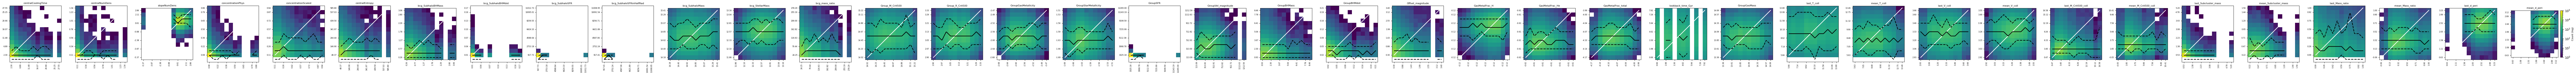

In [10]:
plot_posterior_vs_truth_joint(
    joint_checkpoint="/u/jshera/MAPS_CINN/checkpoints/joint_last.ckpt",
    processed_dir   ="/u/jshera/MAPS_CINN/simclr_results/processed_data",
    n_samples       =200,
    test_frac       =0.1,
    num_bins        =12
)


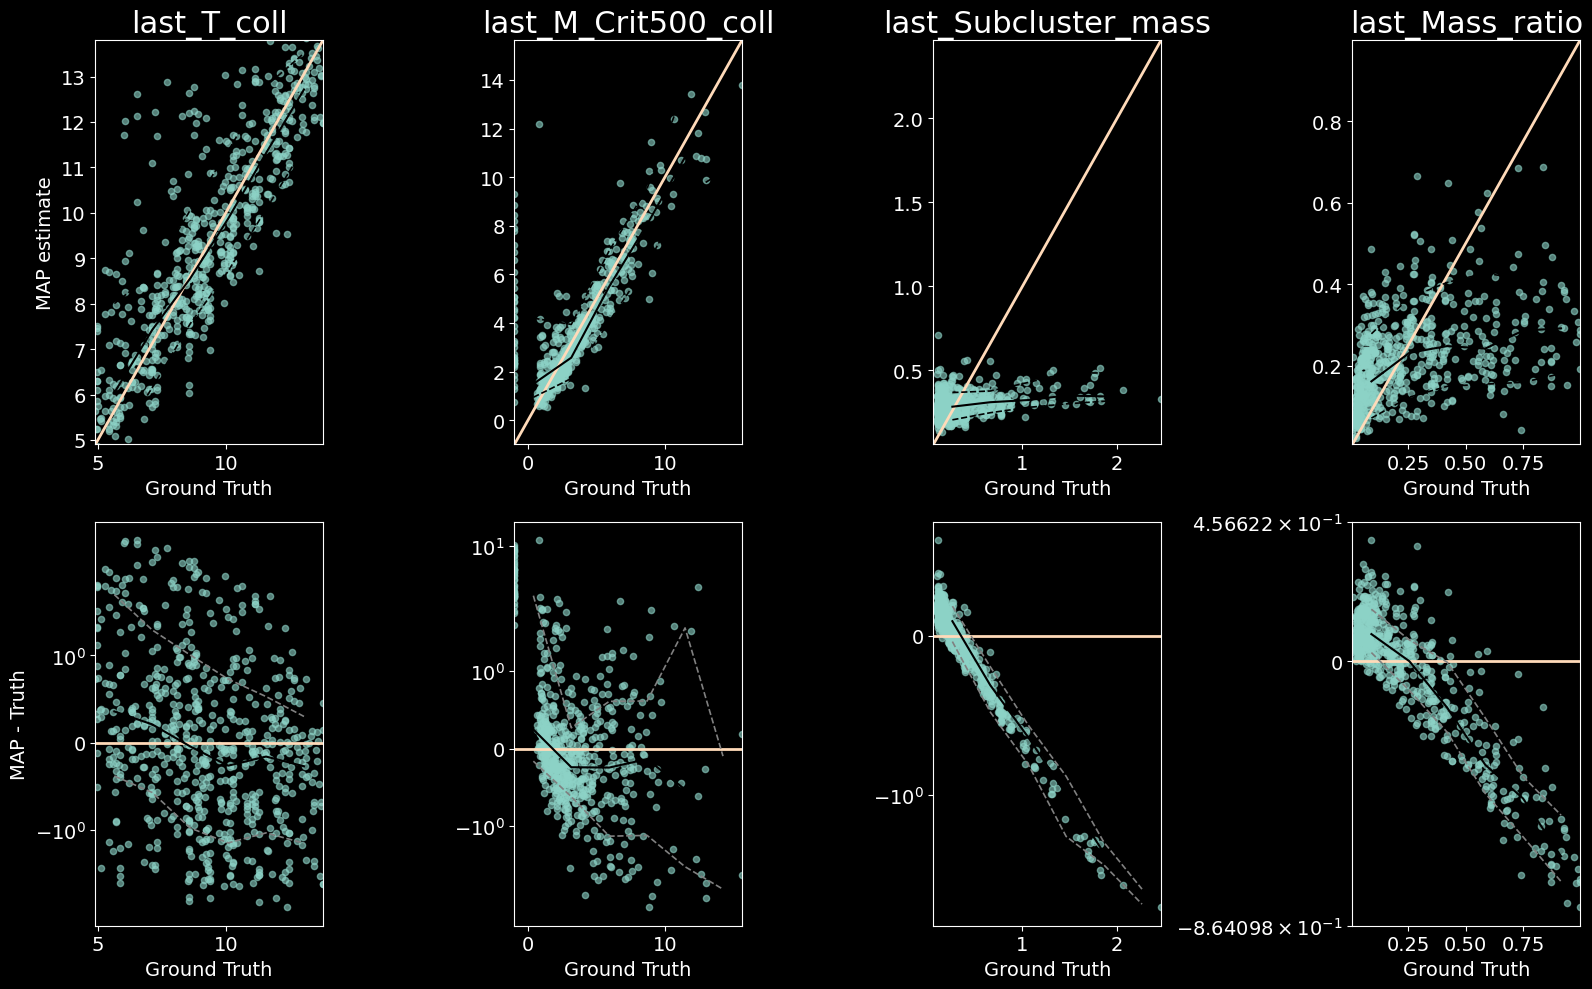

In [ ]:
#!/usr/bin/env python3
import os
import re
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

def normalize_key(fname):
    """
    "snap_050_halo_123456_proj_1.png" → "123456_50"
    """
    base = os.path.splitext(os.path.basename(fname))[0]
    m = re.match(r"^snap_(\d+)_halo_(\d+)_proj_\d+$", base)
    if not m:
        raise ValueError(f"Filename {fname} does not match expected pattern")
    snap, halo = m.group(1), m.group(2)
    return f"{int(halo)}_{int(snap)}"

def load_test_projections(processed_dir, embeddings_npy, filenames_npy,
                          test_frac=0.1, random_state=42):
    # 1) load CSV‐scaled scalars, targets, and meta
    dfX  = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY  = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    X_s_all = dfX.values          # (n_halos, D_obs)
    Y_all   = dfY.values          # (n_halos, D_tar)
    # map halo_snapshot → row index
    key2idx = {
        f"{int(r.HaloID)}_{int(r.Snapshot)}": i
        for i, r in meta.iterrows()
    }

    # 2) load all embeddings + filenames, filter to kept halos
    all_emb   = np.load(embeddings_npy)   # (n_projs_total, D_emb)
    all_files = np.load(filenames_npy)    # (n_projs_total,)
    proj_keys, Es = [], []
    for fn, emb in zip(all_files, all_emb):
        key = normalize_key(fn)
        if key in key2idx:
            proj_keys.append(key)
            Es.append(emb)
    E_proj_raw = np.vstack(Es)             # (n_projs_kept, D_emb)

    # 3) replicate scalar+target rows for each projection
    X_s_proj = np.vstack([ X_s_all[key2idx[k]] for k in proj_keys ])  # (n_projs_kept, D_obs)
    Y_proj   = np.vstack([   Y_all[key2idx[k]]   for k in proj_keys ])  # (n_projs_kept, D_tar)

    # 4) scale embeddings with saved scaler
    emb_sc = joblib.load(os.path.join(processed_dir, "emb_scaler.pkl"))
    E_proj = emb_sc.transform(E_proj_raw)  # (n_projs_kept, D_emb)

    # 5) combine and split
    X_all = np.hstack([X_s_proj, E_proj])  # (n_projs_kept, D_obs + D_emb)
    Y_all = Y_proj                         # (n_projs_kept, D_tar)
    N = X_all.shape[0]
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=test_frac, random_state=random_state)
    X_test = X_all[idx_test]
    Y_test = Y_all[idx_test]
    keys_test = [proj_keys[i] for i in idx_test]

    # also return target column names
    target_names = dfY.columns.tolist()
    return X_test, Y_test, keys_test, target_names

def plot_map_and_error_vs_truth(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    embeddings_npy: str = "embeddings.npy",
    filenames_npy: str  = "filenames.npy",
    n_posterior_samples: int = 600,
    num_bins: int           = 10,
    linthresh: float        = 0.1,
    random_state: int       = 42,
    label_fontsize: int     = 14,
    title_fontsize: int     = 22
):
    """
    Top:    truth vs MAP (with 10th/90th percentile bands)
    Bottom: truth vs (MAP - truth), symlog scale, with 16th/84th bands.
    """
    # load test projections and target names
    X_test, Y_test, keys_test, target_names = load_test_projections(
        processed_dir, embeddings_npy, filenames_npy,
        test_frac=0.1, random_state=random_state
    )
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    N_test, D_obs_comb = X_test.shape
    _, D_tar = Y_test.shape
    assert D_tar == len(target_names)

    # invert Y_test to physical
    true_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(y_dim=D_tar, x_dim=D_obs_comb, hidden_dim=128, n_blocks=12, clamp=2.0)
    ckpt  = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.to(device).eval()

    # compute MAP for each test point
    maps_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logdens = kde.score_samples(grid)
            maps_phys[i, d] = grid[np.argmax(logdens), 0]

    # set up figure
    fig, axes = plt.subplots(2, D_tar, figsize=(4 * D_tar, 10), squeeze=False)

    # bin edges and centers for all targets
    for d in range(D_tar):
        truth = true_phys[:, d]
        mapv  = maps_phys[:, d]
        err   = mapv - truth

        tmin, tmax = truth.min(), truth.max()
        bins = np.linspace(tmin, tmax, num_bins + 1)
        centers = 0.5 * (bins[:-1] + bins[1:])
        inds = np.digitize(truth, bins) - 1
        inds = np.clip(inds, 0, num_bins - 1)

        # compute percentile bands for MAP
        med_map = np.full(num_bins, np.nan)
        lo_map  = np.full(num_bins, np.nan)
        hi_map  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            sel = mapv[inds == b]
            if sel.size:
                med_map[b] = np.median(sel)
                lo_map[b], hi_map[b] = np.percentile(sel, [10, 90])

        # top row: truth vs MAP
        ax = axes[0, d]
        ax.scatter(truth, mapv, s=20, alpha=0.6)
        ax.plot([tmin, tmax], [tmin, tmax], color='peachpuff', lw=2)
        ax.plot(centers, med_map, '-',  lw=1.5, color='black')
        ax.plot(centers, lo_map,  '--', lw=1.2, color='black')
        ax.plot(centers, hi_map,  '--', lw=1.2, color='black')
        ax.set_xlim(tmin, tmax); ax.set_ylim(tmin, tmax)
        ax.set_title(target_names[d], fontsize=title_fontsize)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax.tick_params(labelsize=label_fontsize)

        # bottom row: truth vs error
        # compute percentile bands for error
        med_err = np.full(num_bins, np.nan)
        lo_err  = np.full(num_bins, np.nan)
        hi_err  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            sel = err[inds == b]
            if sel.size:
                med_err[b] = np.median(sel)
                lo_err[b], hi_err[b] = np.percentile(sel, [16, 84])

        ax = axes[1, d]
        ax.scatter(truth, err, s=20, alpha=0.6)
        ax.axhline(0, color='peachpuff', lw=2)
        ax.plot(centers, med_err, '-',  lw=1.5, color='black')
        ax.plot(centers, lo_err,  '--', lw=1.2, color='gray')
        ax.plot(centers, hi_err,  '--', lw=1.2, color='gray')
        ax.set_yscale("symlog", linthresh=linthresh)
        ax.set_xlim(tmin, tmax)
        ax.set_xlabel("Ground Truth", fontsize=label_fontsize)
        if d == 0:
            ax.set_ylabel("MAP - Truth", fontsize=label_fontsize)
        ax.tick_params(labelsize=label_fontsize)

    plt.tight_layout()
    fig.savefig("Fig15.2-3map_and_error_vs_truth_combined.pdf", bbox_inches='tight')
    fig.savefig("Fig15.2-3map_and_error_vs_truth_combined.png", bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    plot_map_and_error_vs_truth(
        model_checkpoint="best_cluster_cinn_combined.pt",
        processed_dir="processed_data",
        embeddings_npy="embeddings.npy",
        filenames_npy="filenames.npy",
        n_posterior_samples=100,
        num_bins=6,
        linthresh=1.5,
        random_state=42
    )


In [14]:
import os
import yaml
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from PIL import Image

from models.joint_model  import JointModel
from data.data_augmentor import DataAugmentor

# Must match your processed_data/Y.csv columns
TARGET_COLS = [
    'centralCoolingTime','centralNumDens','slopeNumDens',
    'concentrationPhys','concentrationScaled','centralEntropy',
    'bcg_SubhaloBHMass','bcg_SubhaloBHMdot','bcg_SubhaloSFR',
    'bcg_SubhaloSFRinHalfRad','bcg_SubhaloMass','bcg_StellarMass',
    'bcg_mass_ratio','Group_M_Crit500','Group_R_Crit500',
    'GroupGasMetallicity','GroupStarMetallicity','GroupSFR',
    'GroupVel_magnitude','GroupBHMass','GroupBHMdot',
    'Offset_magnitude','GasMetalFrac_H','GasMetalFrac_He',
    'GasMetalFrac_total','lookback_time_Gyr','GroupGasMass',
    'last_T_coll','mean_T_coll','last_V_coll','mean_V_coll',
    'last_M_Crit500_coll','mean_M_Crit500_coll',
    'last_Subcluster_mass','mean_Subcluster_mass',
    'last_Mass_ratio','mean_Mass_ratio','last_d_peri','mean_d_peri'
]

def plot_map_and_error_vs_truth_joint(
    joint_checkpoint:    str,
    processed_dir:       str,
    n_posterior_samples: int   = 600,
    num_bins:            int   = 10,
    linthresh:           float = 0.1,
    test_frac:           float = 0.1,
    random_state:        int   = 42,
    label_fontsize:      int   = 14,
    title_fontsize:      int   = 18
):
    """
    Plots Truth vs MAP and Truth vs (MAP – Truth) for your JointModel pipeline.
    """
    # 1) Where the raw images live:
    ds_cfg   = yaml.safe_load(open("configs/dataset_config.yaml"))["dataset"]
    data_dir = ds_cfg["data_path"]

    # 2) Load joint (SSL+cINN) model:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    joint  = (JointModel
              .load_from_checkpoint(joint_checkpoint)
              .eval()
              .to(device))

    # 3) Single-view test transform:
    augmentor = DataAugmentor(
        "configs/augmentations_config.yaml",
        "configs/dataset_config.yaml",
        "configs/main_config.yaml"
    )
    test_tf = augmentor.get_test_transform()

    # 4) Load processed Y + meta, replicate projections:
    dfY   = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    meta  = pd.read_csv(os.path.join(processed_dir, "meta.csv"))
    meta["cluster_idx"] = meta.index
    Y_clust = dfY.values

    projs = [1,2,3]
    df_rep = pd.concat([meta.assign(proj=p) for p in projs],
                       ignore_index=True)
    Y_rep = np.repeat(Y_clust, len(projs), axis=0)

    # 5) Split out test projections:
    N_all = len(df_rep)
    _, idx_test = train_test_split(
        np.arange(N_all),
        test_size=test_frac,
        random_state=random_state
    )
    df_test = df_rep.iloc[idx_test].reset_index(drop=True)
    Y_test  = Y_rep[idx_test]
    print(f"Total projections: {N_all}, test set: {len(idx_test)}")

    # 6) Build priors in physical units:
    tar_sc    = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    true_phys = tar_sc.inverse_transform(Y_test)
    N_test, D_tar = true_phys.shape
    assert D_tar == len(TARGET_COLS)

    edges = [
        np.linspace(true_phys[:,d].min(),
                    true_phys[:,d].max(),
                    num_bins+1)
        for d in range(D_tar)
    ]
    prior_bin_idx = np.stack([
        np.digitize(true_phys[:,d], edges[d][1:-1], right=False)
        for d in range(D_tar)
    ], axis=1)

    # 7) Storage for MAP & error bands:
    maps_phys = np.zeros((N_test, D_tar))
    med_map = np.full((D_tar, num_bins), np.nan)
    lo_map  = np.full((D_tar, num_bins), np.nan)
    hi_map  = np.full((D_tar, num_bins), np.nan)
    med_err = np.full((D_tar, num_bins), np.nan)
    lo_err  = np.full((D_tar, num_bins), np.nan)
    hi_err  = np.full((D_tar, num_bins), np.nan)

    # 8) Loop test set, sample posterior, compute MAP:
    for i, row in df_test.iterrows():
        snap = int(row.Snapshot)
        halo = int(row.HaloID)
        proj = int(row.proj)
        fname = f"snap_{snap:03d}_halo_{halo}_proj_{proj}.jpg"
        path  = os.path.join(data_dir, fname)
        if not os.path.isfile(path):
            raise FileNotFoundError(f"No image at {path}")

        img = Image.open(path).convert("RGB")
        x   = test_tf(img).unsqueeze(0).to(device)
        h0  = joint.backbone(x).flatten(1)

        Z   = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = joint.cinn.inverse(Z, h0.repeat(n_posterior_samples,1))
        Ys   = inv[0] if isinstance(inv, tuple) else inv
        phys = tar_sc.inverse_transform(Ys.cpu().numpy())

        for d in range(D_tar):
            arr = phys[:,d][:,None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid    = np.linspace(arr.min(), arr.max(), 200)[:,None]
            logdens = kde.score_samples(grid)
            maps_phys[i,d] = grid[np.argmax(logdens),0]

    # 9) Aggregate into bins:
    err = maps_phys - true_phys
    for d in range(D_tar):
        inds = prior_bin_idx[:,d]
        for b in range(num_bins):
            sel_map = maps_phys[inds==b, d]
            sel_err = err   [inds==b, d]
            if sel_map.size:
                med, lo, hi = np.median(sel_map), *np.percentile(sel_map, [10,90])
                med_map[d,b], lo_map[d,b], hi_map[d,b] = med, lo, hi
            if sel_err.size:
                m, loe, hie = np.median(sel_err), *np.percentile(sel_err, [16,84])
                med_err[d,b], lo_err[d,b], hi_err[d,b] = m, loe, hie

    # 10) Plot two rows of D_tar columns:
    fig, axes = plt.subplots(2, D_tar, figsize=(4*D_tar,10), squeeze=False)
    centers = [0.5*(e[:-1]+e[1:]) for e in edges]

    for d in range(D_tar):
        # Top: truth vs MAP
        ax1 = axes[0,d]
        ax1.scatter(true_phys[:,d], maps_phys[:,d], s=10, alpha=0.5)
        mn, mx = true_phys[:,d].min(), true_phys[:,d].max()
        ax1.plot([mn,mx],[mn,mx],'k--', lw=1)
        ax1.plot(centers[d], med_map[d], '-', color='C1', lw=2)
        ax1.plot(centers[d], lo_map[d],  '--', color='C1', lw=1.5)
        ax1.plot(centers[d], hi_map[d],  '--', color='C1', lw=1.5)
        if d==0:
            ax1.set_ylabel("MAP estimate", fontsize=label_fontsize)
        ax1.set_xlabel("Truth", fontsize=label_fontsize)
        ax1.set_title(TARGET_COLS[d], fontsize=title_fontsize)

        # Bottom: truth vs error
        ax2 = axes[1,d]
        ax2.scatter(true_phys[:,d], err[:,d], s=10, alpha=0.5)
        ax2.axhline(0, color='k', lw=1)
        ax2.plot(centers[d], med_err[d], '-', color='C2', lw=2)
        ax2.plot(centers[d], lo_err[d],  '--', color='C2', lw=1.5)
        ax2.plot(centers[d], hi_err[d],  '--', color='C2', lw=1.5)
        ax2.set_yscale("symlog", linthresh=linthresh)
        if d==0:
            ax2.set_ylabel("MAP − Truth", fontsize=label_fontsize)
        ax2.set_xlabel("Truth", fontsize=label_fontsize)

    plt.tight_layout()
    plt.show()


/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Total projections: 6330, test set: 633


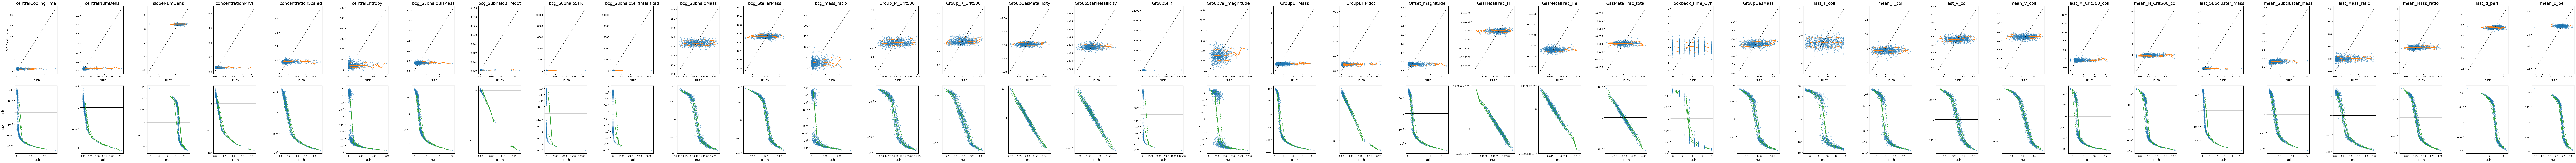

In [15]:
plot_map_and_error_vs_truth_joint(
    joint_checkpoint    = "/u/jshera/MAPS_CINN/checkpoints/joint_last.ckpt",
    processed_dir       = "/u/jshera/MAPS_CINN/simclr_results/processed_data",
    n_posterior_samples = 600,
    num_bins            = 10,
    linthresh           = 0.1,
    test_frac           = 0.1
)
